# FrameAxis Analysis

In this notebook the process of calculating the FrameAxis values are explained, furthmore the FrameAxis values are evluated for the given datasets.

## SemEval 2023 Dataset

### Prepare the data

In [1]:
frameaxis_file_name = "frameaxis_semeval_mft_experiment"

In [2]:
label_fontsize = 12
title_fontsize = 16
ticks_fontsize = 12
legend_fontsize = 12

In [3]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import io
import torch

In [4]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [5]:
# load frameaxis data
with open(f'../../data/frameaxis/semeval/{frameaxis_file_name}.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

# load mfc data
df_mfc = pd.DataFrame(json.load(open("../../data/semeval/muse-dlf/semeval_train.json")))

In [6]:
df_mfc.set_index('article_id', inplace=True)
df_frameaxis.set_index('article_id', inplace=True)

In [7]:
# join df_mfc and df_frameaxis row by row
df_merged = pd.concat([df_mfc, df_frameaxis], axis=1)

df_merged['type'] = pd.Categorical(df_merged['type'], categories=["opinion", "reporting", "satire"], ordered=True)

In [8]:
df_merged['frames'] = df_merged.apply(lambda row: ', '.join([col for col in df_merged.columns[2:-1] if row[col] == 1]), axis=1)

In [9]:
for col in ['authority_bias', 'authority_intensity', 'care_bias',
       'care_intensity', 'fairness_bias', 'fairness_intensity', 'loyalty_bias',
       'loyalty_intensity', 'sanctity_bias', 'sanctity_intensity']:
    if isinstance(df_merged[col][0], torch.Tensor):
        df_merged[col] = df_merged[col].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)


C:\Users\elias\AppData\Local\Temp\ipykernel_5664\1462405778.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(df_merged[col][0], torch.Tensor):


In [10]:
df_merged['text'] = df_merged['text'].astype(str)
# add article_id as col from row index
df_merged['article_id'] = df_merged.index

In [11]:
frame_columns = ['Capacity_and_resources', 'Crime_and_punishment', 'Cultural_identity', 'Economic',
                 'External_regulation_and_reputation', 'Fairness_and_equality', 'Health_and_safety',
                 'Legality_Constitutionality_and_jurisprudence', 'Morality', 'Policy_prescription_and_evaluation',
                 'Political', 'Public_opinion', 'Quality_of_life', 'Security_and_defense']

# Create an empty list to store the new rows
new_rows = []

# Iterate through each row in the dataframe
for idx, row in df_merged.iterrows():
    # For each row, iterate through the frame columns and check if they have a value of 1
    for frame in frame_columns:
        if row[frame] == 1:
            # Create a new row with the 'frames' column set to the current frame
            new_row = row.drop(frame_columns).copy()
            new_row['frames'] = frame
            new_rows.append(new_row)

# Create a new dataframe from the new rows
new_df = pd.DataFrame(new_rows)

In [12]:
df_sentence_single = new_df.copy()

df_sentence_single['frame_type'] = df_sentence_single['frames'] + " - " + df_sentence_single['type'].astype(str)

In [13]:
df_sentence_multi = df_merged.copy()

df_sentence_multi['frame_type'] = df_sentence_multi['frames'] + " - " + df_sentence_multi['type'].astype(str)

In [14]:
bias_columns = [
    "care_bias",
    "loyalty_bias",
    "authority_bias",
    "fairness_bias",
    "sanctity_bias",
]

intensity_columns = [
    "care_intensity",
    "loyalty_intensity",
    "authority_intensity",
    "fairness_intensity",
    "sanctity_intensity",
]

In [33]:
# Define color palette for each microframe tone
color_palette = {
    "Authority": ("#95d2b3", "#4db480", "#2e6d4d"),
    "Care": ("#ef9c66", "#d86317", "#7c390d"),
    "Fairness": ("#d37676", "#ac3737", "#5f1e1e"),
    "Loyalty": ("#f1ef99", "#e5e13f", "#a7a417"),
    "Sanctity": ("#ad88c6", "#7c4b9d", "#452a58"),
}

In [34]:
microframe_map = {
    "care": "Care/Harm",
    "loyalty": "Loyalty/Betrayal",
    "authority": "Authority/Subversion",
    "fairness": "Fairness/Cheating",
    "sanctity": "Sanctity/Degradation",
}

In [35]:
frame_map = {
    "Capacity_and_resources": "Capacity and resources",
    "Crime_and_punishment": "Crime and punishment",
    "Cultural_identity": "Cultural identity",
    "Economic": "Economic",
    "External_regulation_and_reputation": "External regulation and reputation",
    "Fairness_and_equality": "Fairness and equality",
    "Health_and_safety": "Health and safety",
    "Legality_Constitutionality_and_jurisprudence": "Legality, constitutionality, and jurisprudence",
    "Morality": "Morality",
    "Policy_prescription_and_evaluation": "Policy prescription and evaluation",
    "Political": "Political",
    "Public_opinion": "Public opinion",
    "Quality_of_life": "Quality of life",
    "Security_and_defense": "Security and defense",
}

In [36]:
df_article_single = df_sentence_single.groupby(['article_id', 'frames']).agg({
    'authority_bias': 'mean',
    'authority_intensity': 'mean',
    'care_bias': 'mean',
    'care_intensity': 'mean',
    'fairness_bias': 'mean',
    'fairness_intensity': 'mean',
    'loyalty_bias': 'mean',
    'loyalty_intensity': 'mean',
    'sanctity_bias': 'mean',
    'sanctity_intensity': 'mean',
    'text': ' '.join,  
    'type': 'first',  
    'frame_type': 'first'
}).reset_index()


In [ ]:
df_article_multi = df_sentence_multi.groupby(['article_id']).agg({
    'authority_bias': 'mean',
    'authority_intensity': 'mean',
    'care_bias': 'mean',
    'care_intensity': 'mean',
    'fairness_bias': 'mean',
    'fairness_intensity': 'mean',
    'loyalty_bias': 'mean',
    'loyalty_intensity': 'mean',
    'sanctity_bias': 'mean',
    'sanctity_intensity': 'mean',
    'text': ' '.join, 
    'type': 'first', 
    'frame_type': 'first',
    'frames': 'first'
}).reset_index()

### Bias Values Across Different Types and Document Frames

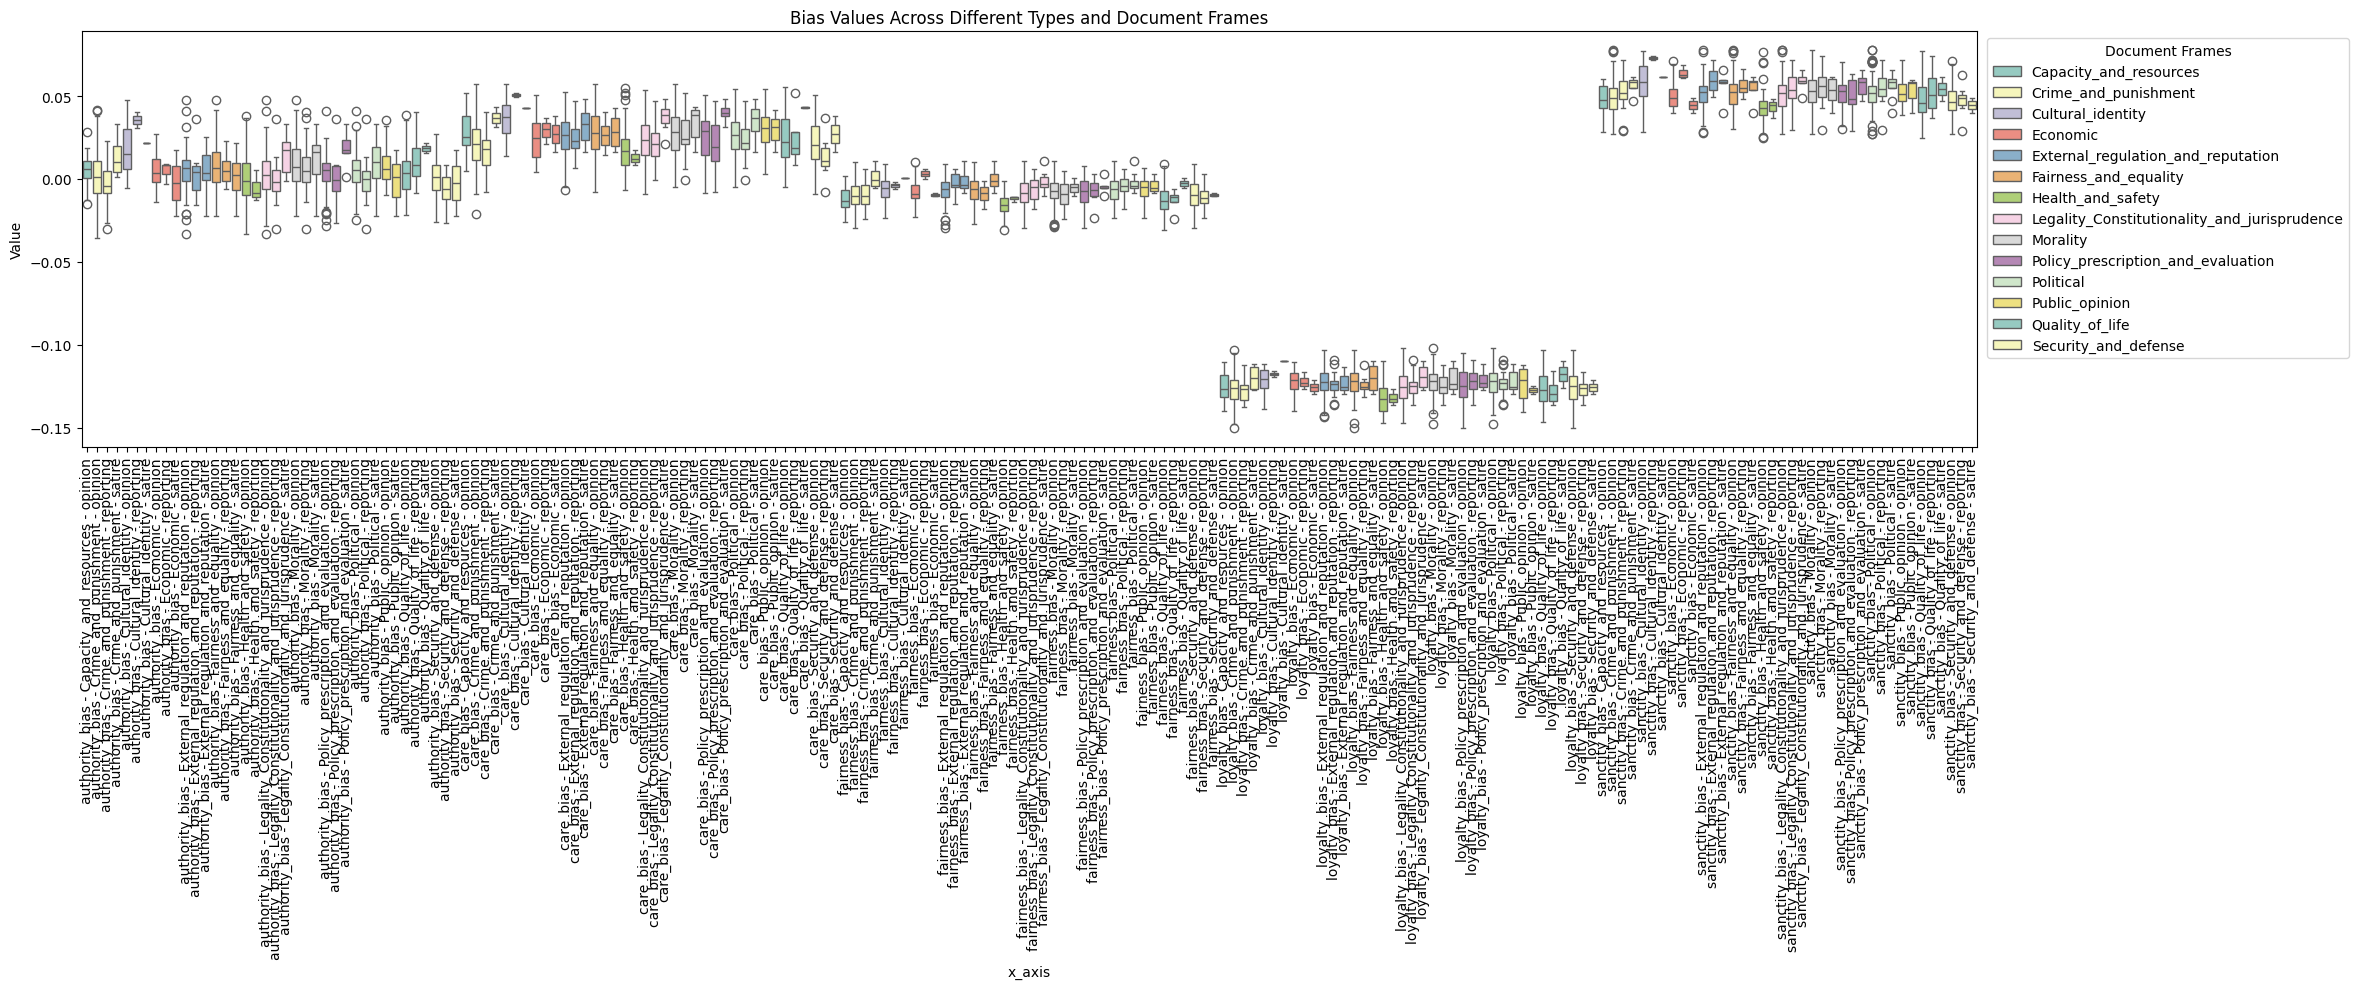

In [ ]:
def plot_bias_foundations(df, foundations, types=['opinion', 'reporting', 'satire']):

    # Filtering the DataFrame for the types we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=[ 'frames', 'type'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'frames', and 'type'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['frames']} - {x['type']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'frames', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'frames'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='frames', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Bias Values Across Different Types and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df_article_single,  ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'])

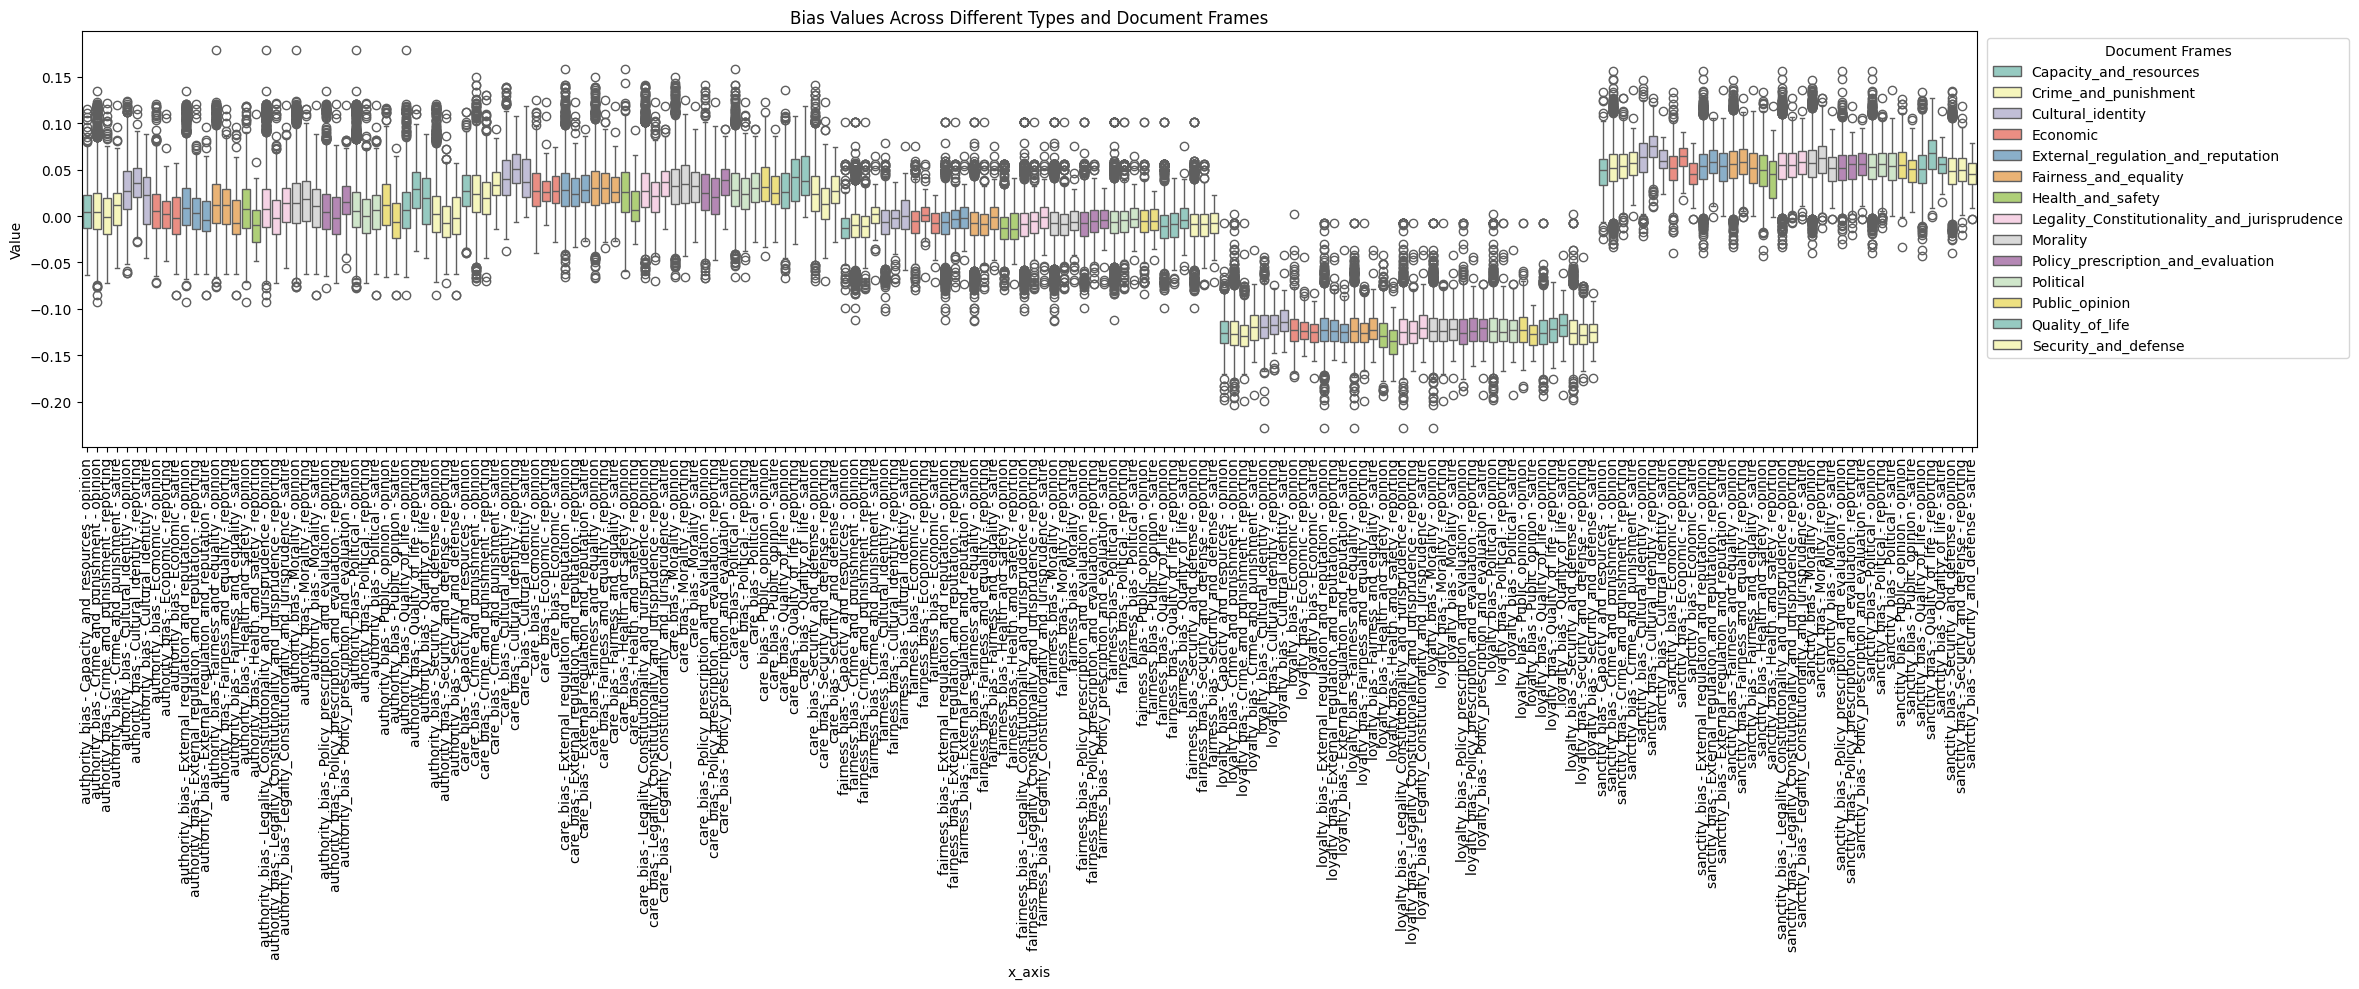

In [ ]:
# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df_sentence_single,  ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'])

### Intensity Values Across Different Types and Document Frames

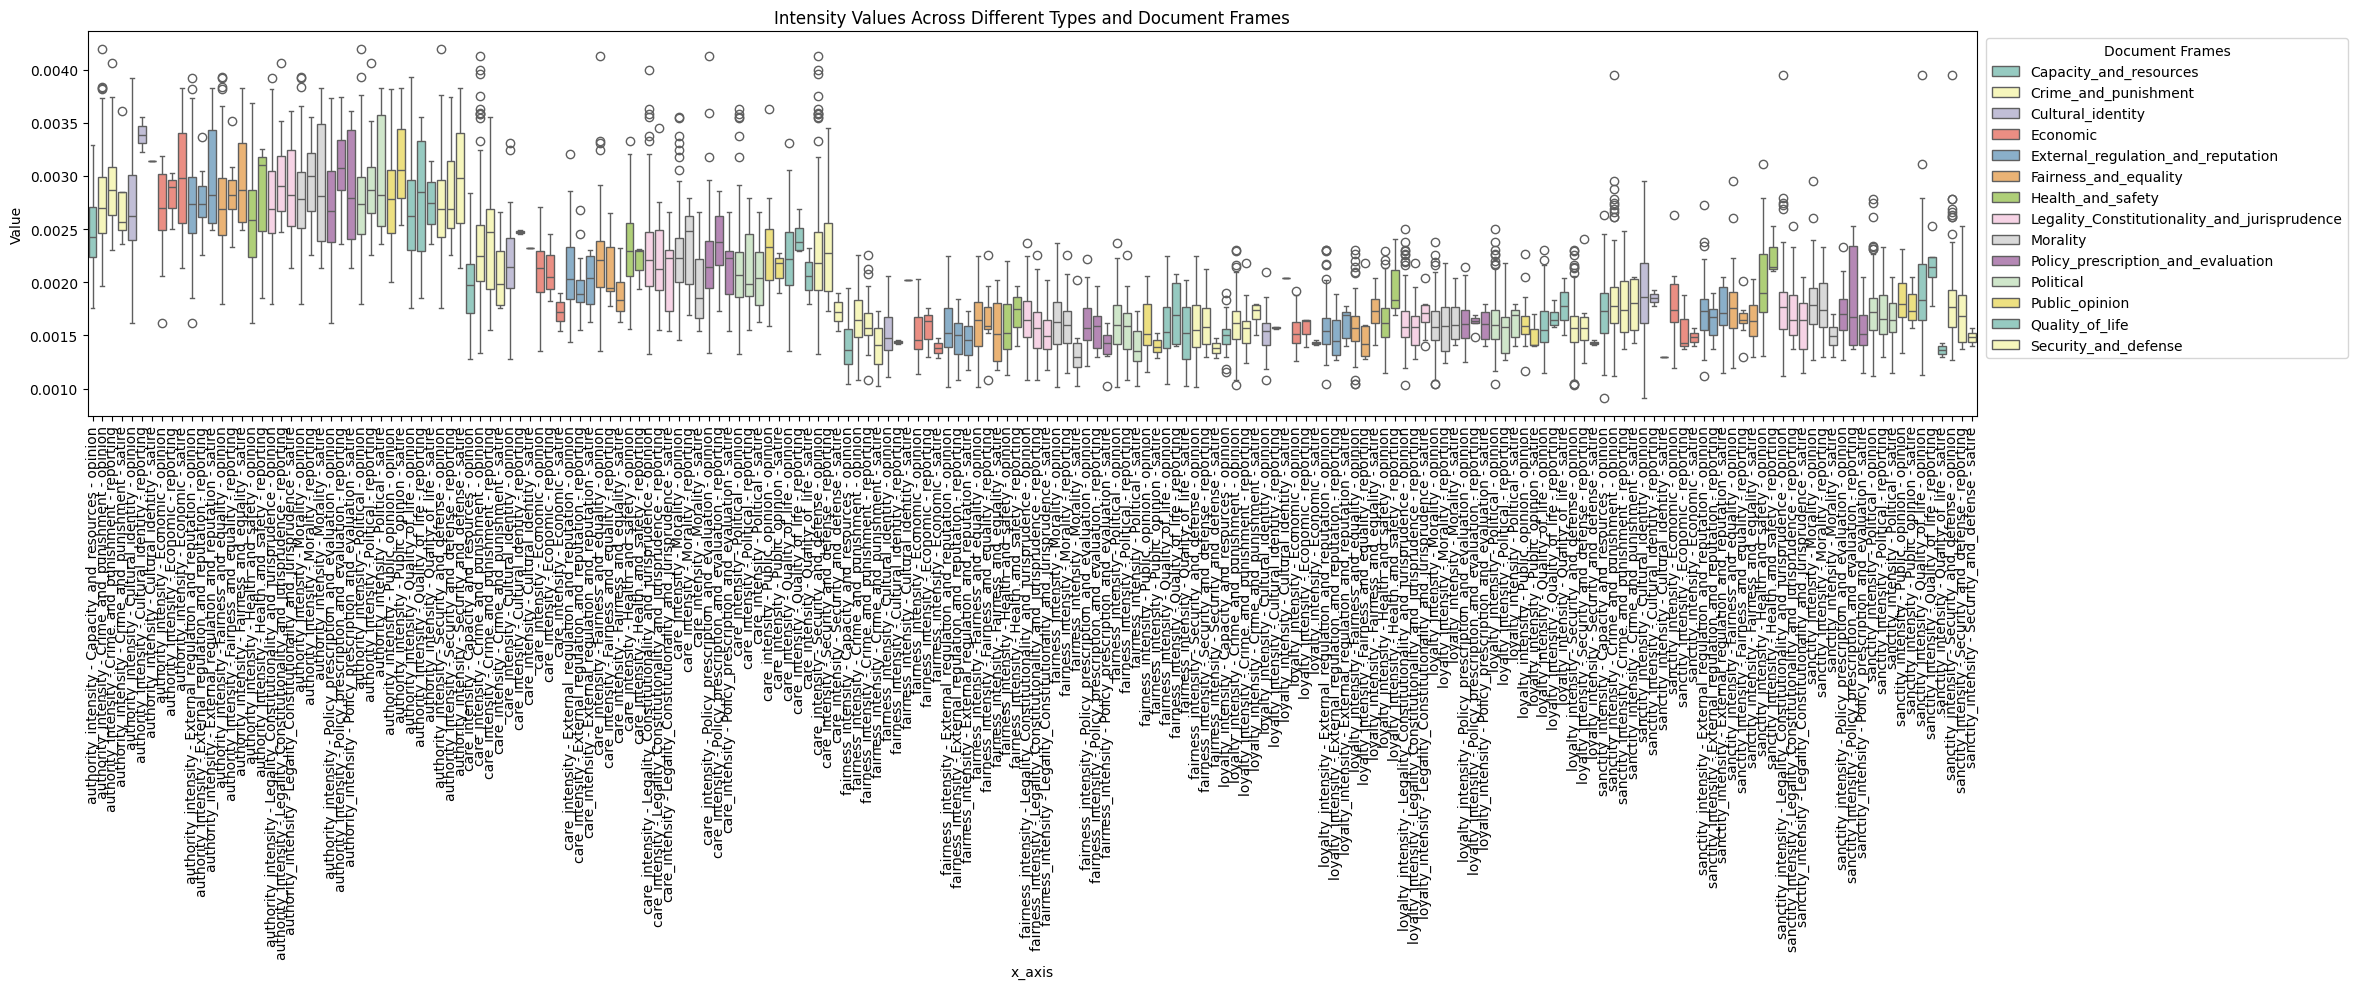

In [38]:
def plot_intensity_foundations(df, foundations, types=['opinion', 'reporting', 'satire']):
    # Filtering the DataFrame for the types we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['article_id', 'frames', 'type', 'text'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'frames', and 'type'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['frames']} - {x['type']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'frames', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'frames'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='frames', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Intensity Values Across Different Types and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'
plot_intensity_foundations(df_article_single,  ['authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'], types=['opinion', 'reporting', 'satire'])

### Microframe Bias Across Different Types (Opinion, Reporting and Satire)

In [39]:
color_palette

{'Authority': ('#95d2b3', '#4db480', '#2e6d4d'),
 'Care': ('#ef9c66', '#d86317', '#7c390d'),
 'Fairness': ('#d37676', '#ac3737', '#5f1e1e'),
 'Loyalty': ('#f1ef99', '#e5e13f', '#a7a417'),
 'Sanctity': ('#ad88c6', '#7c4b9d', '#452a58')}

C:\Users\elias\AppData\Local\Temp\ipykernel_5664\597179523.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette=colors, order=x_ticks_order)


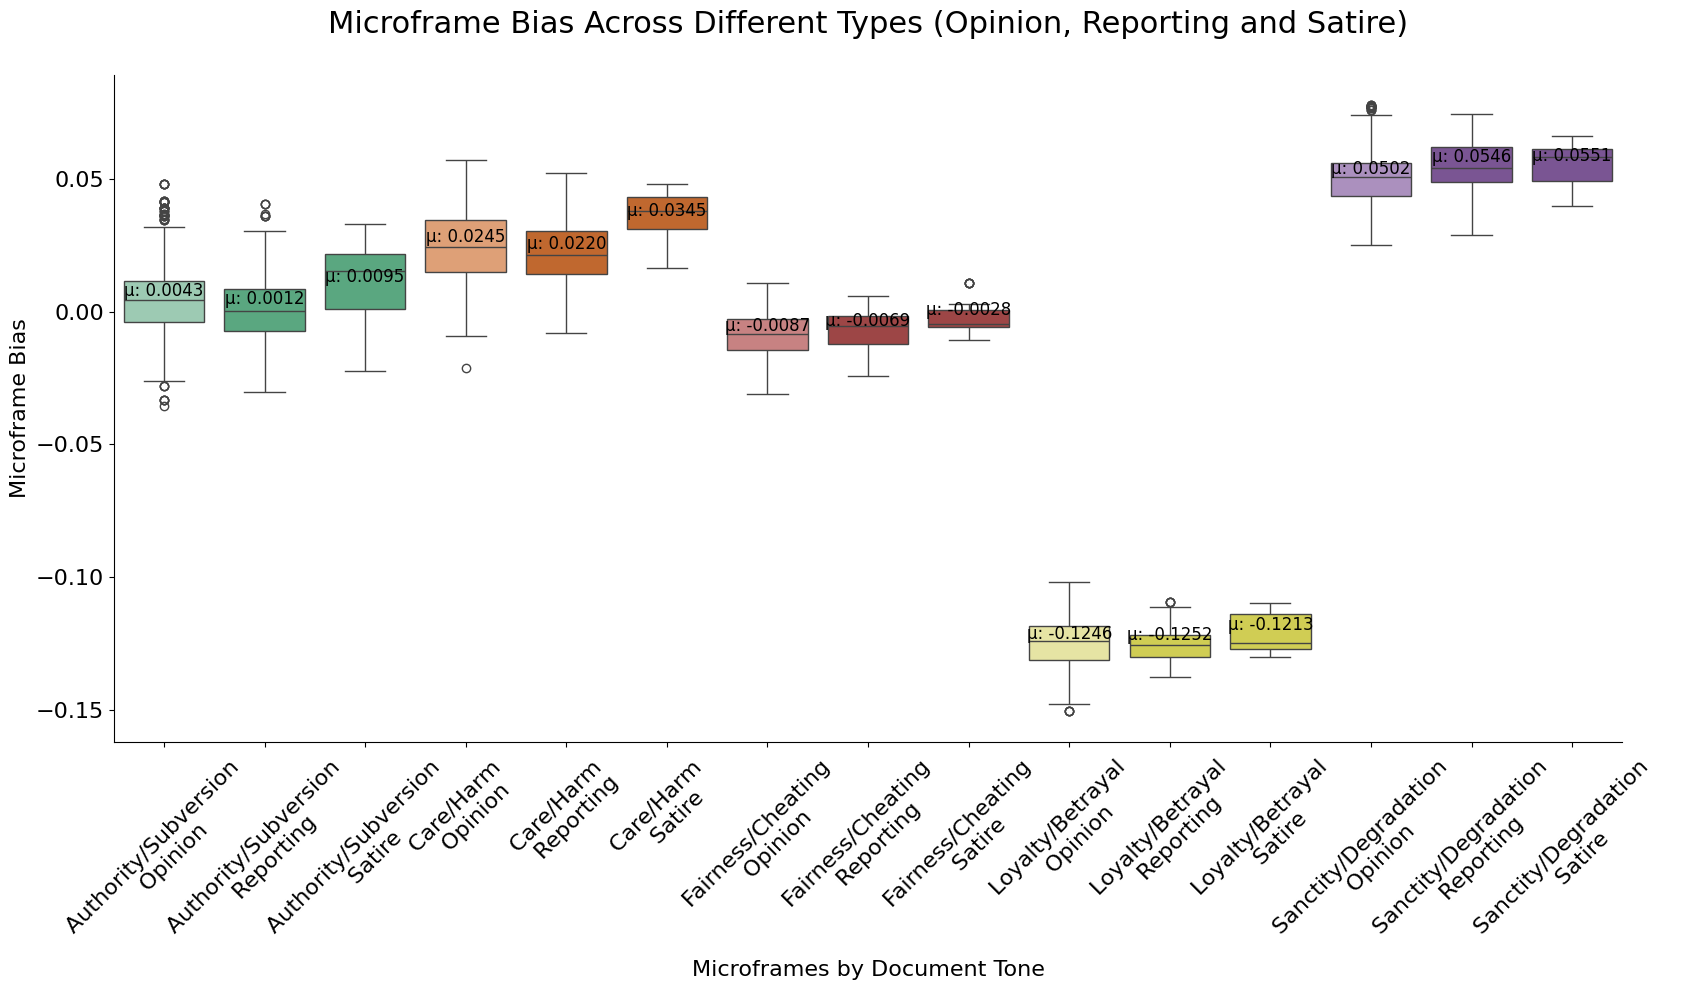

In [45]:

def plot_bias_foundations(df, foundations, types=['opinion', 'reporting', 'satire'], microframe_map=None):
    # Filtering the DataFrame for the types we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['type'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Map the metrics to their correct names using microframe_map if provided
    if microframe_map:
        melted_bias['Metric'] = melted_bias['Metric'].apply(lambda x: microframe_map.get(x.split('_')[0], x.split('_')[0]))

    # Creating a composite key for plotting, which combines the 'Metric' and 'type'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} \n {x['type'].capitalize()}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    colors = [
        color_palette[mf][0] if "Opinion" in xtick else color_palette[mf][1] if "Reporting" else color_palette[mf][2]
        for xtick in x_ticks_order
        for mf in color_palette.keys()
        if mf in xtick
    ]

    # Plotting
    plt.figure(figsize=(17, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette=colors, order=x_ticks_order)

    plt.title('Microframe Bias Across Different Types (Opinion, Reporting and Satire)\n', fontsize=22)
    plt.xlabel('Microframes by Document Tone', fontsize=16)
    plt.ylabel('Microframe Bias', fontsize=16)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)

    # Remove frames around the plot
    sns.despine()

    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_bias[melted_bias['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', color='black', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df_article_single, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'], microframe_map=microframe_map)

### Microframe Intensity Across Different Types (Opinion, Reporting and Satire)

C:\Users\elias\AppData\Local\Temp\ipykernel_5664\2242251526.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_intensity, palette='Set3', order=x_ticks_order)


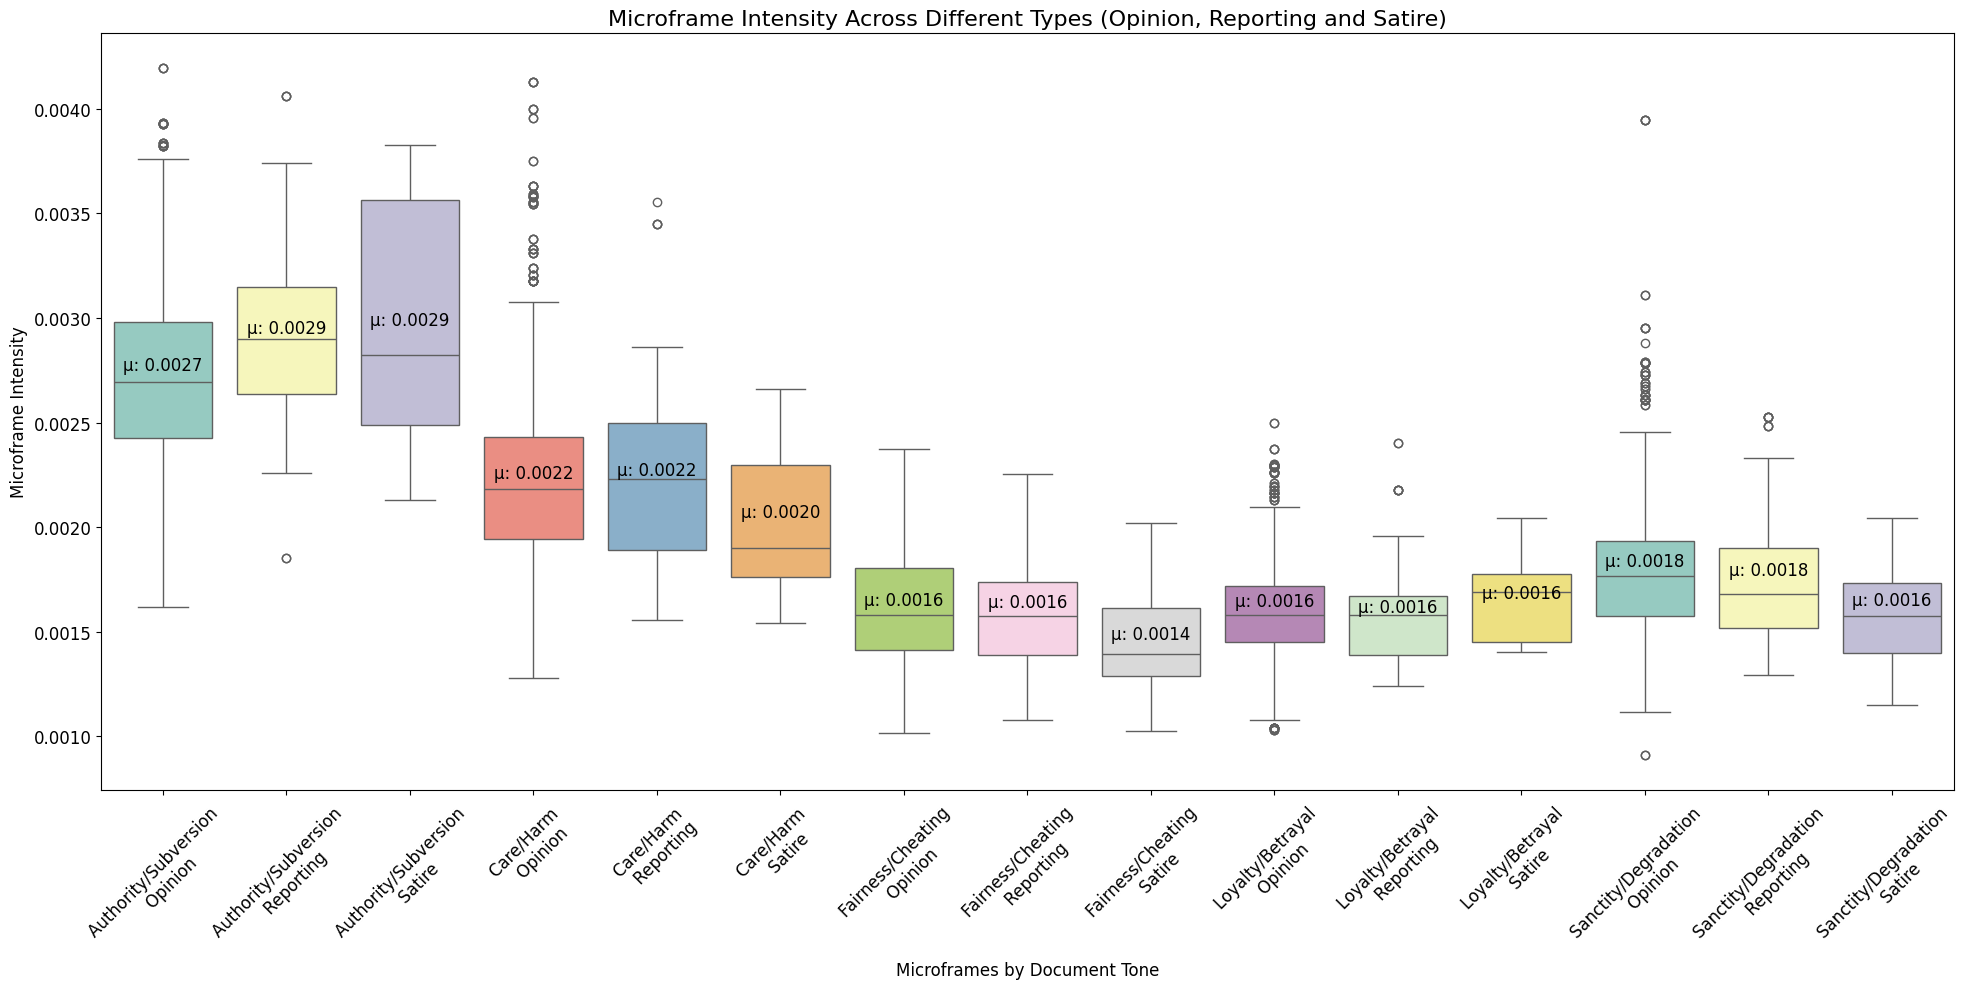

In [24]:
def plot_intensity_foundations(df, foundations, types=['opinion', 'reporting', 'satire']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    melted_intensity = df.melt(id_vars=['type'], value_vars=intensity_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_intensity.dropna(inplace=True)
    
    # Map the metrics to their correct names using microframe_map if provided
    if microframe_map:
        melted_intensity['Metric'] = melted_intensity['Metric'].apply(lambda x: microframe_map.get(x.split('_')[0], x.split('_')[0]))

    # Creating a composite key for plotting, which combines the 'Metric' and 'type'
    melted_intensity['x_axis'] = melted_intensity.apply(
        lambda x: f"{x['Metric']} \n {x['type'].capitalize()}", axis=1
    )
    
    # Sort the melted DataFrame to define the order of boxplots
    melted_intensity.sort_values(by=['Metric', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_intensity['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_intensity, palette='Set3', order=x_ticks_order)

    plt.title('Microframe Intensity Across Different Types (Opinion, Reporting and Satire)', fontsize=title_fontsize)
    plt.xlabel('Microframes by Document Tone', fontsize=label_fontsize)
    plt.ylabel('Microframe Intensity', fontsize=label_fontsize)
    plt.xticks(rotation=45, fontsize=ticks_fontsize) 
    plt.yticks(fontsize=ticks_fontsize)

    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_intensity[melted_intensity['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', color='black', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_intensity_foundations(df_article_single, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'])

### (SINGLE FRAME) Plot Bias and Intensity for each foundation WITHOUT type

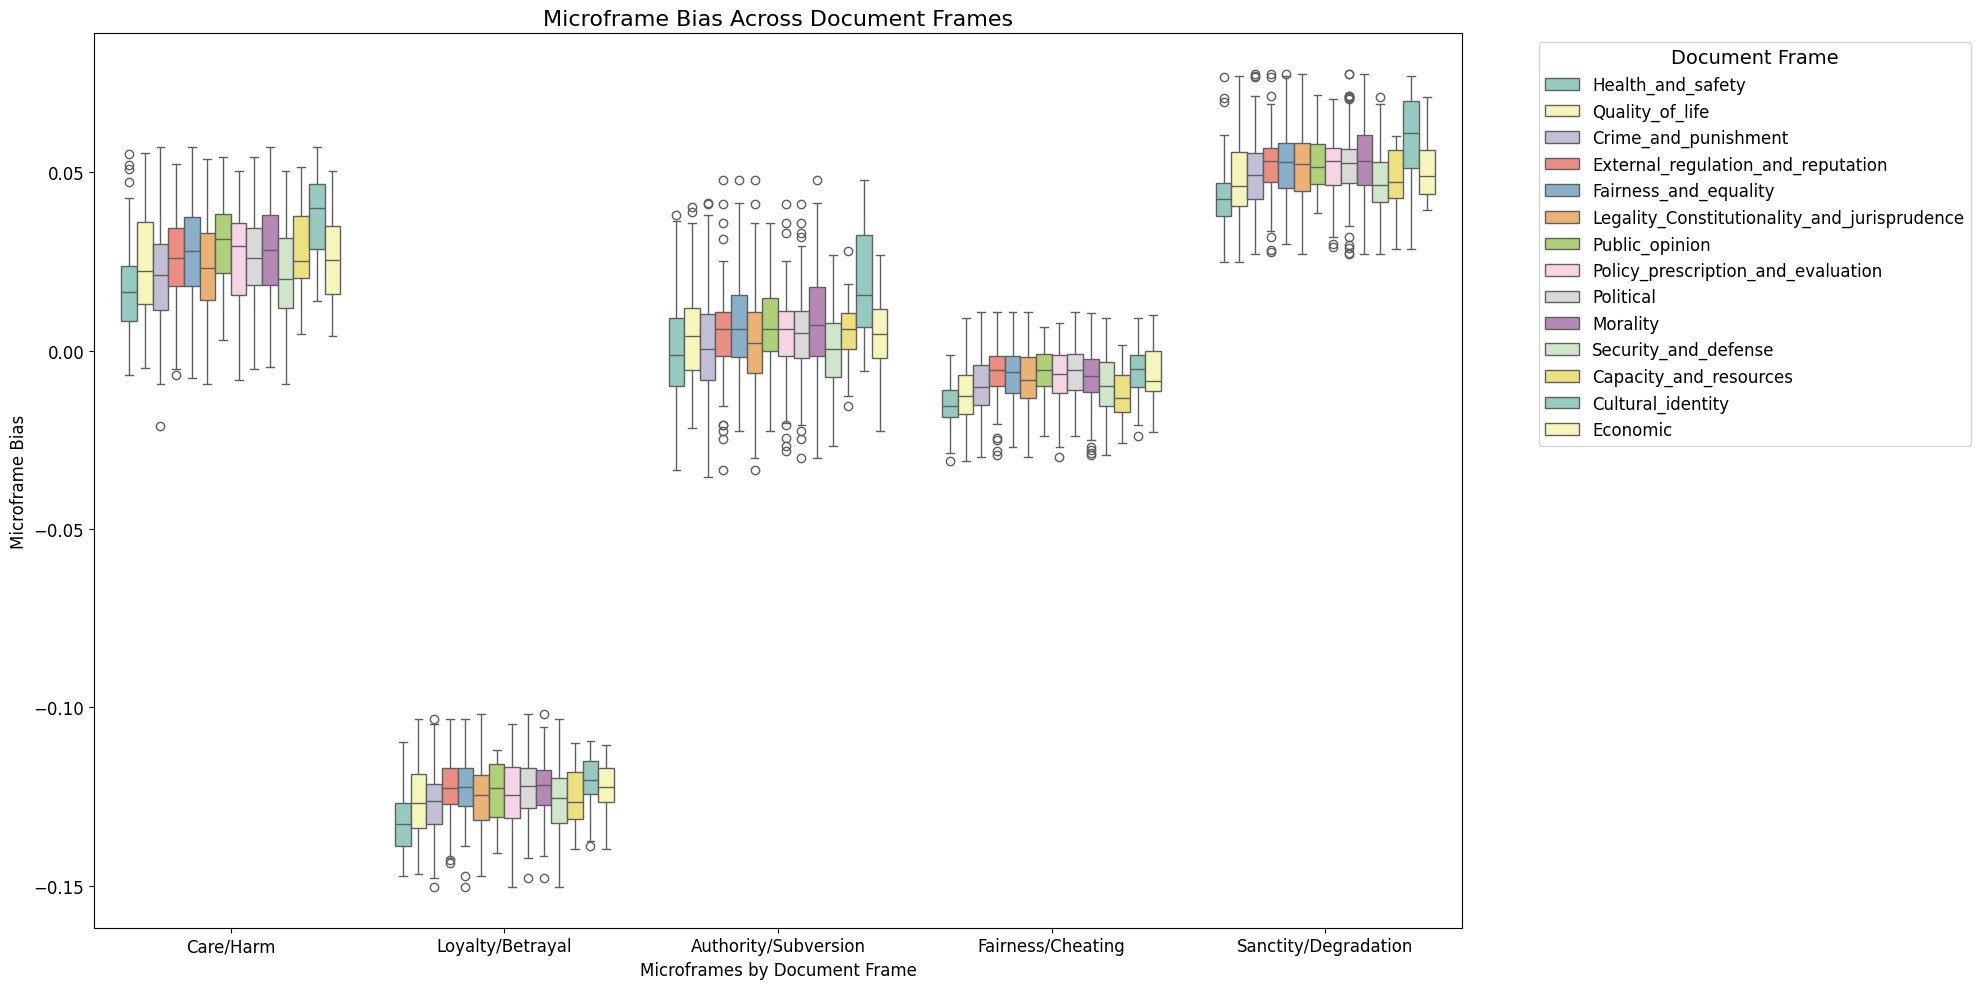

In [25]:
melted_bias = df_article_single.melt(
    id_vars=["frames"],
    value_vars=bias_columns,
    var_name="Metric",
    value_name="Value",
)
melted_bias["Type"] = "Bias"

melted_bias["Metric"] = melted_bias["Metric"].apply(
    lambda x: microframe_map.get(x.split("_")[0], x.split("_")[0])
)

# Combining bias and intensity data
combined_data = pd.concat([melted_bias])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(
    x="Metric", y="Value", hue="frames", data=combined_data, palette="Set3"
)
plt.title("Microframe Bias Across Document Frames", fontsize=title_fontsize)
plt.xlabel("Microframes by Document Frame", fontsize=label_fontsize)
plt.ylabel("Microframe Bias", fontsize=label_fontsize)
plt.xticks(rotation=0, fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.legend(
    title="Document Frame",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=legend_fontsize,
    title_fontsize=legend_fontsize + 2,
)
plt.tight_layout()
plt.show()

In [49]:
df_article_single.columns

Index(['article_id', 'frames', 'authority_bias', 'authority_intensity',
       'care_bias', 'care_intensity', 'fairness_bias', 'fairness_intensity',
       'loyalty_bias', 'loyalty_intensity', 'sanctity_bias',
       'sanctity_intensity', 'text', 'type', 'frame_type'],
      dtype='object')

C:\Users\elias\AppData\Local\Temp\ipykernel_5664\2332582756.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


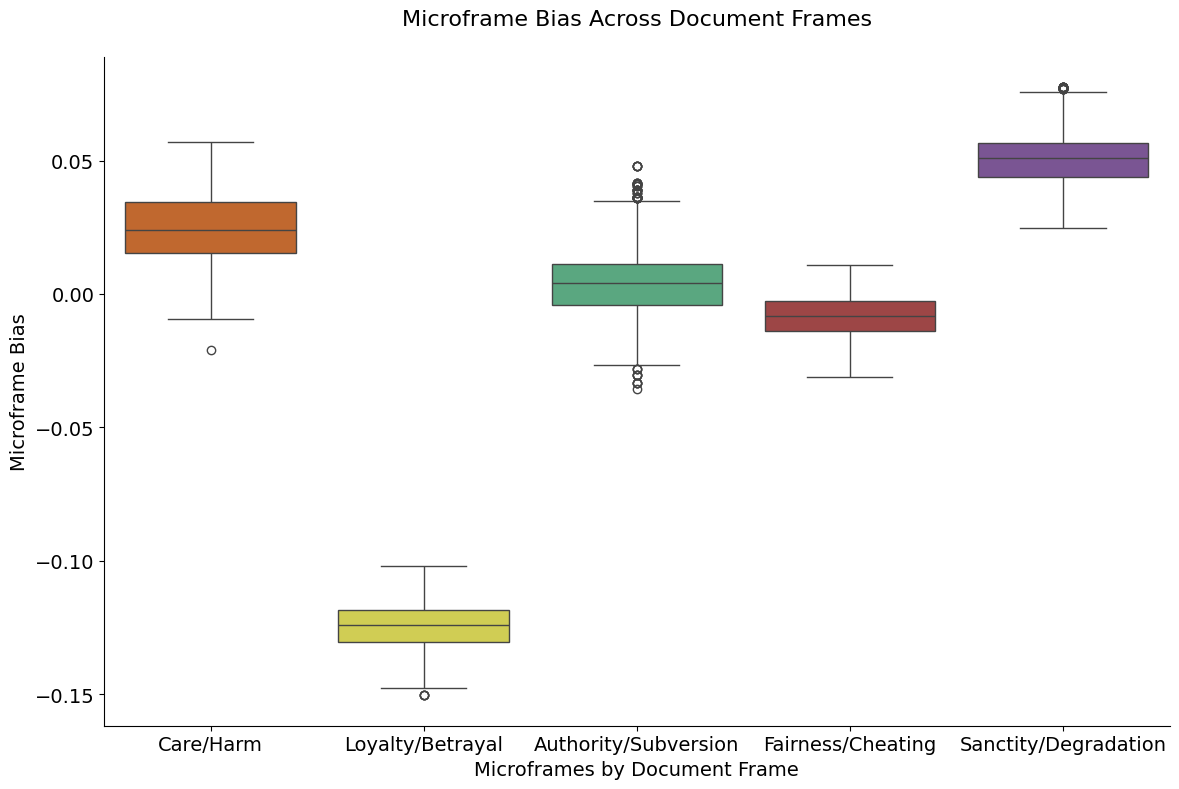

In [58]:
melted_bias = df_article_single.melt(
    id_vars=["frames"],
    value_vars=bias_columns,
    var_name="Metric",
    value_name="Value",
)
melted_bias["Type"] = "Bias"

melted_bias["Metric"] = melted_bias["Metric"].apply(
    lambda x: microframe_map.get(x.split("_")[0], x.split("_")[0])
)

# The order of x-ticks is defined by the sorted unique values of 'x_axis'
x_ticks_order = melted_bias['Metric'].unique()

colors = [
    color_palette[mf][0] if "Opinion" in xtick else color_palette[mf][1] if "Reporting" else color_palette[mf][2]
    for xtick in x_ticks_order
    for mf in color_palette.keys()
    if mf in xtick
]

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="Metric", y="Value", data=melted_bias, palette=colors
)

sns.despine()

plt.title("Microframe Bias Across Document Frames\n", fontsize=16)
plt.xlabel("Microframes by Document Frame", fontsize=14)
plt.ylabel("Microframe Bias", fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

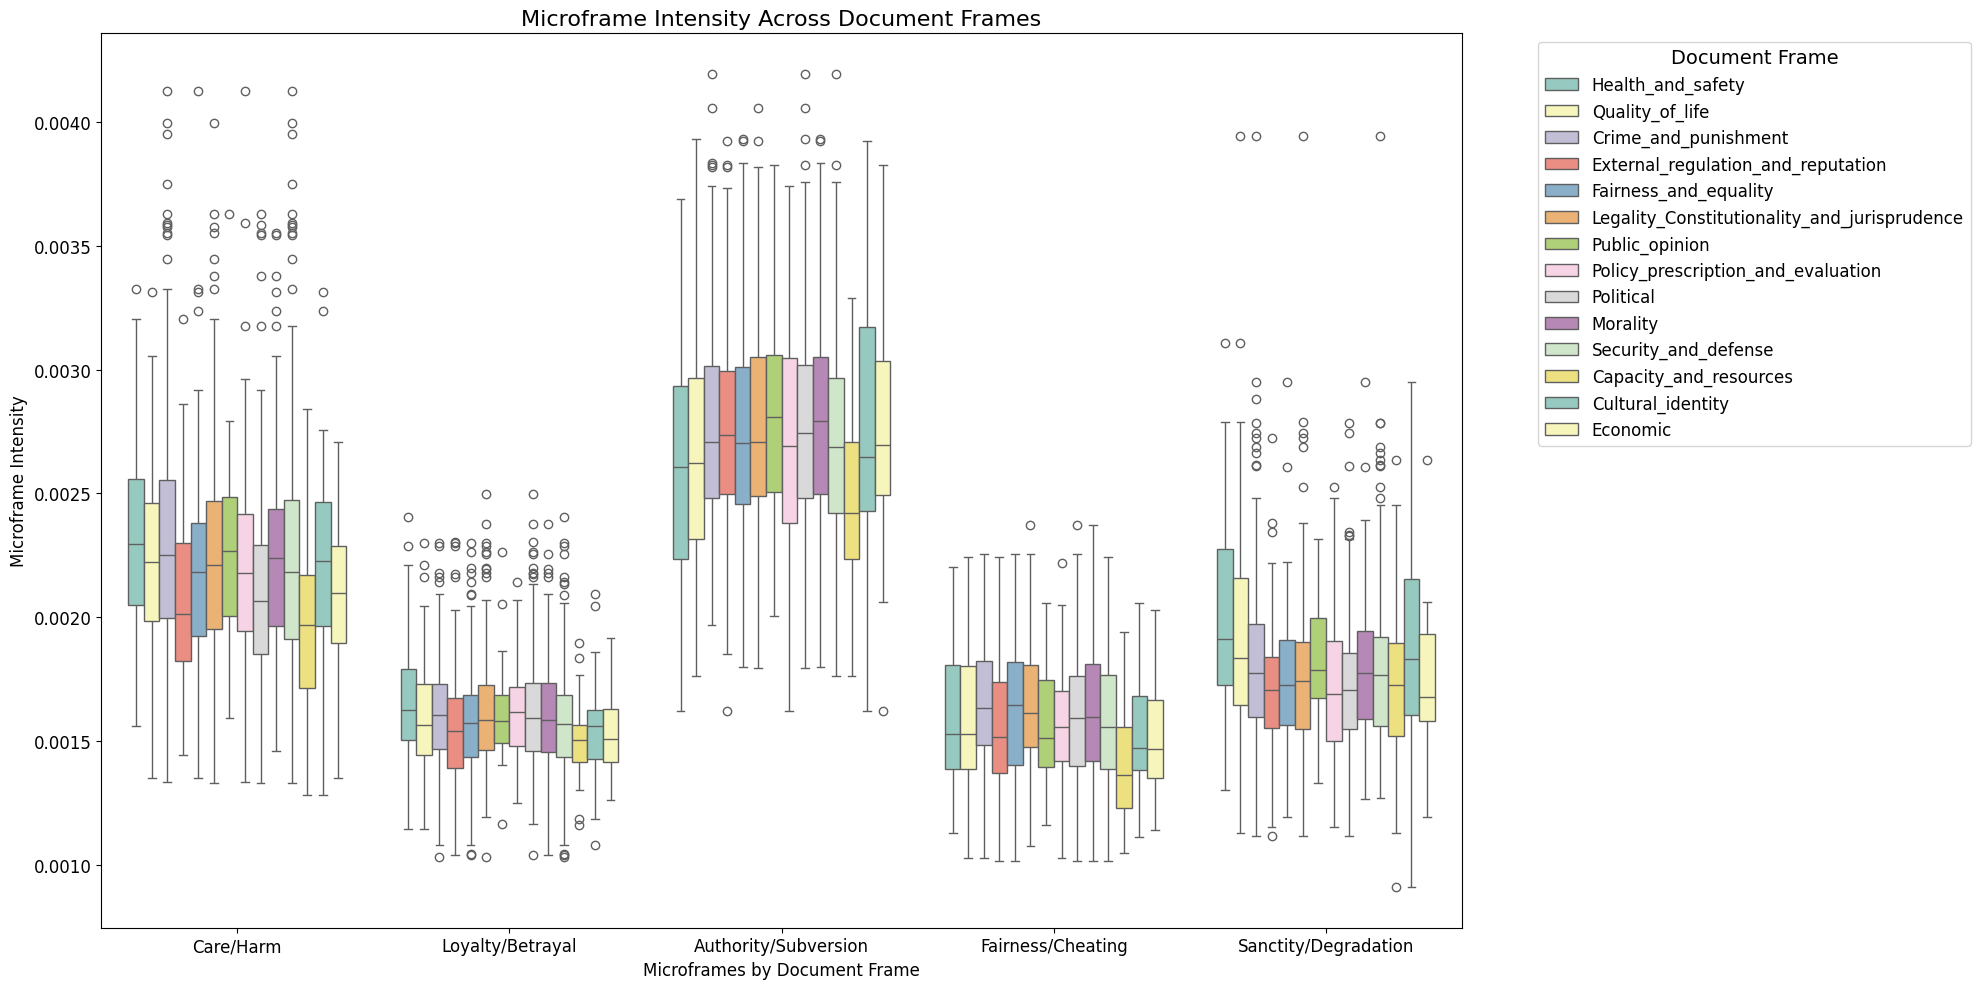

In [26]:
melted_intensity = df_article_single.melt(
    id_vars=["frames"],
    value_vars=intensity_columns,
    var_name="Metric",
    value_name="Value",
)
melted_intensity["Type"] = "Intensity"

melted_intensity["Metric"] = melted_intensity["Metric"].apply(
    lambda x: microframe_map.get(x.split("_")[0], x.split("_")[0])
)

# Combining bias and intensity data
combined_data = pd.concat([melted_intensity])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(
    x="Metric", y="Value", hue="frames", data=combined_data, palette="Set3"
)
plt.title("Microframe Intensity Across Document Frames", fontsize=title_fontsize)
plt.xlabel("Microframes by Document Frame", fontsize=label_fontsize)
plt.ylabel("Microframe Intensity", fontsize=label_fontsize)
plt.xticks(rotation=0, fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.legend(
    title="Document Frame",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=legend_fontsize,
    title_fontsize=legend_fontsize + 2,
)
plt.tight_layout()
plt.show()

### Frame Combination Analysis

In [ ]:
# Step 2: Split and reaggregate frame combinations
from collections import Counter

# Function to split frame combinations and count occurrences
def split_and_count(frame_combinations):
    all_combinations = []
    for combination in frame_combinations:
        frames = combination.split(', ')
        # Generate all subsets of the frames
        for i in range(1, len(frames) + 1):
            for j in range(len(frames) - i + 1):
                subset = ', '.join(sorted(frames[j:j + i]))
                all_combinations.append(subset)
    return Counter(all_combinations)

# Apply the function to the frame_combination column
frame_combination_counter = split_and_count(df_article_multi['frames'])

# Convert the counter to a DataFrame for better readability
frame_combination_df = pd.DataFrame.from_dict(frame_combination_counter, orient='index', columns=['count']).reset_index()
frame_combination_df.columns = ['frames', 'count']

In [ ]:
top_combinations = frame_combination_df.nlargest(20, 'count')[['frames', 'count']]

top_combinations

frames  count
19                                          Political    235
3                                Crime_and_punishment    227
6        Legality_Constitutionality_and_jurisprudence    203
30                                           Morality    203
48                               Security_and_defense    187
4                  External_regulation_and_reputation    121
5                               Fairness_and_equality    115
33                                Morality, Political     92
1                                     Quality_of_life     87
32  Legality_Constitutionality_and_jurisprudence, ...     85
50                    Political, Security_and_defense     75
18                 Policy_prescription_and_evaluation     65
20  Crime_and_punishment, Legality_Constitutionali...     64
0                                   Health_and_safety     61
42  Legality_Constitutionality_and_jurisprudence, ...     56
10  Fairness_and_equality, Legality_Constitutional...     51
8   Crime_and_punishment, External_regulation_and_...     47
60                    Fairness_and_equality, Morality     45
31        Crime_and_punishment, Fairness_and_equality     41
36  Legality_Constitutionality_and_jurisprudence, ...     41

### Plot Bias & Intensity for single foundation WITHOUT tone

C:\Users\elias\AppData\Local\Temp\ipykernel_5664\3259545547.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')
C:\Users\elias\AppData\Local\Temp\ipykernel_5664\3259545547.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=ticks_fontsize)


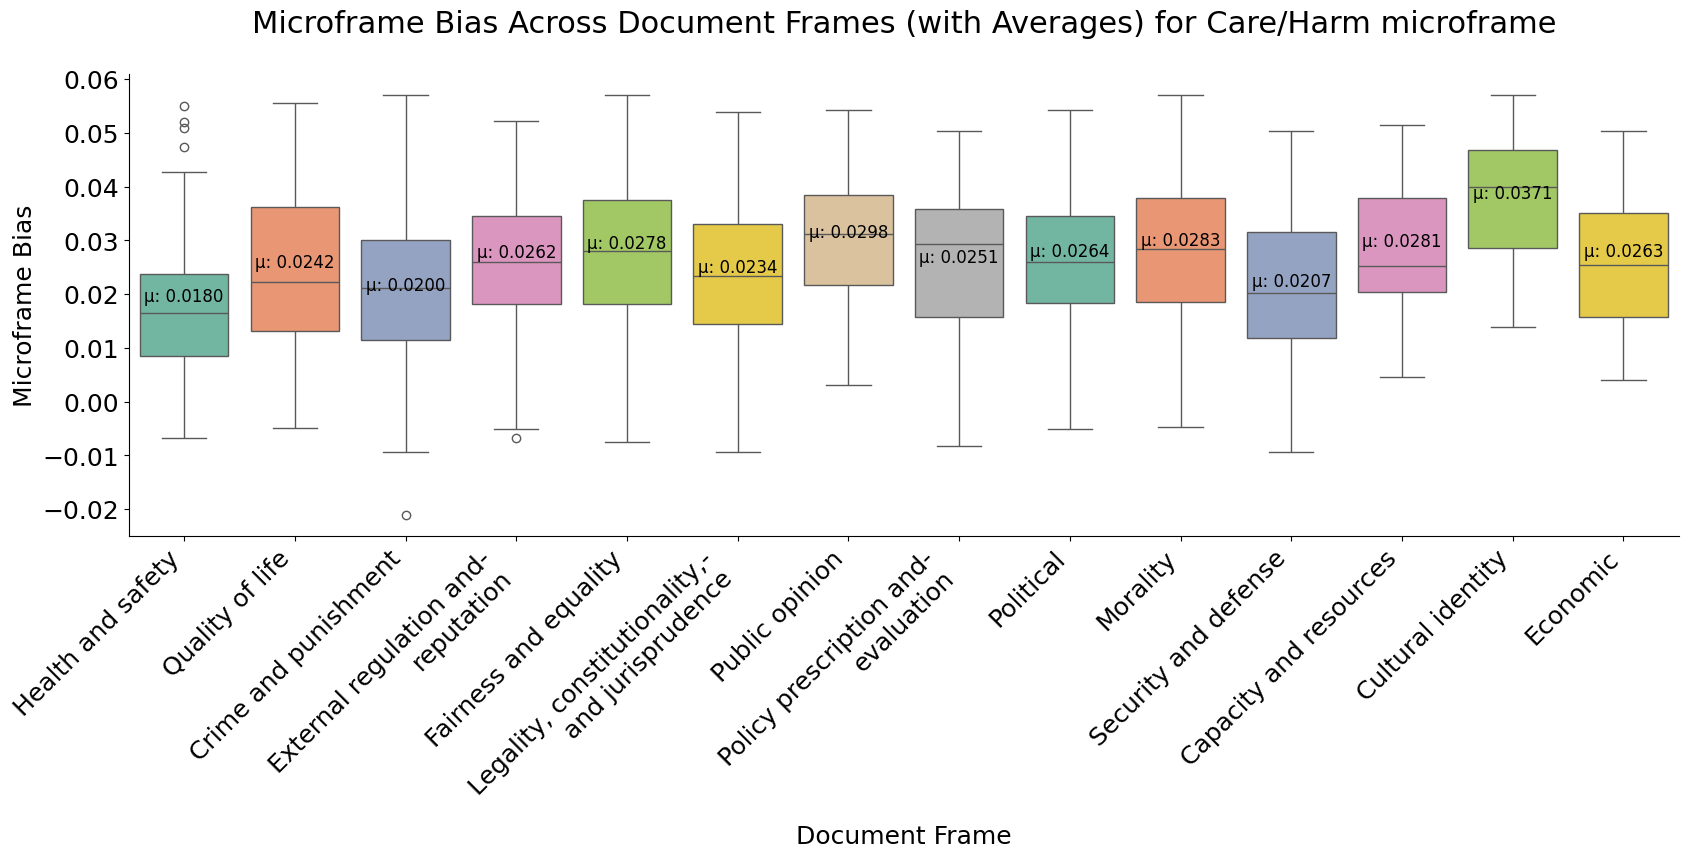

C:\Users\elias\AppData\Local\Temp\ipykernel_5664\3259545547.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')
C:\Users\elias\AppData\Local\Temp\ipykernel_5664\3259545547.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=ticks_fontsize)


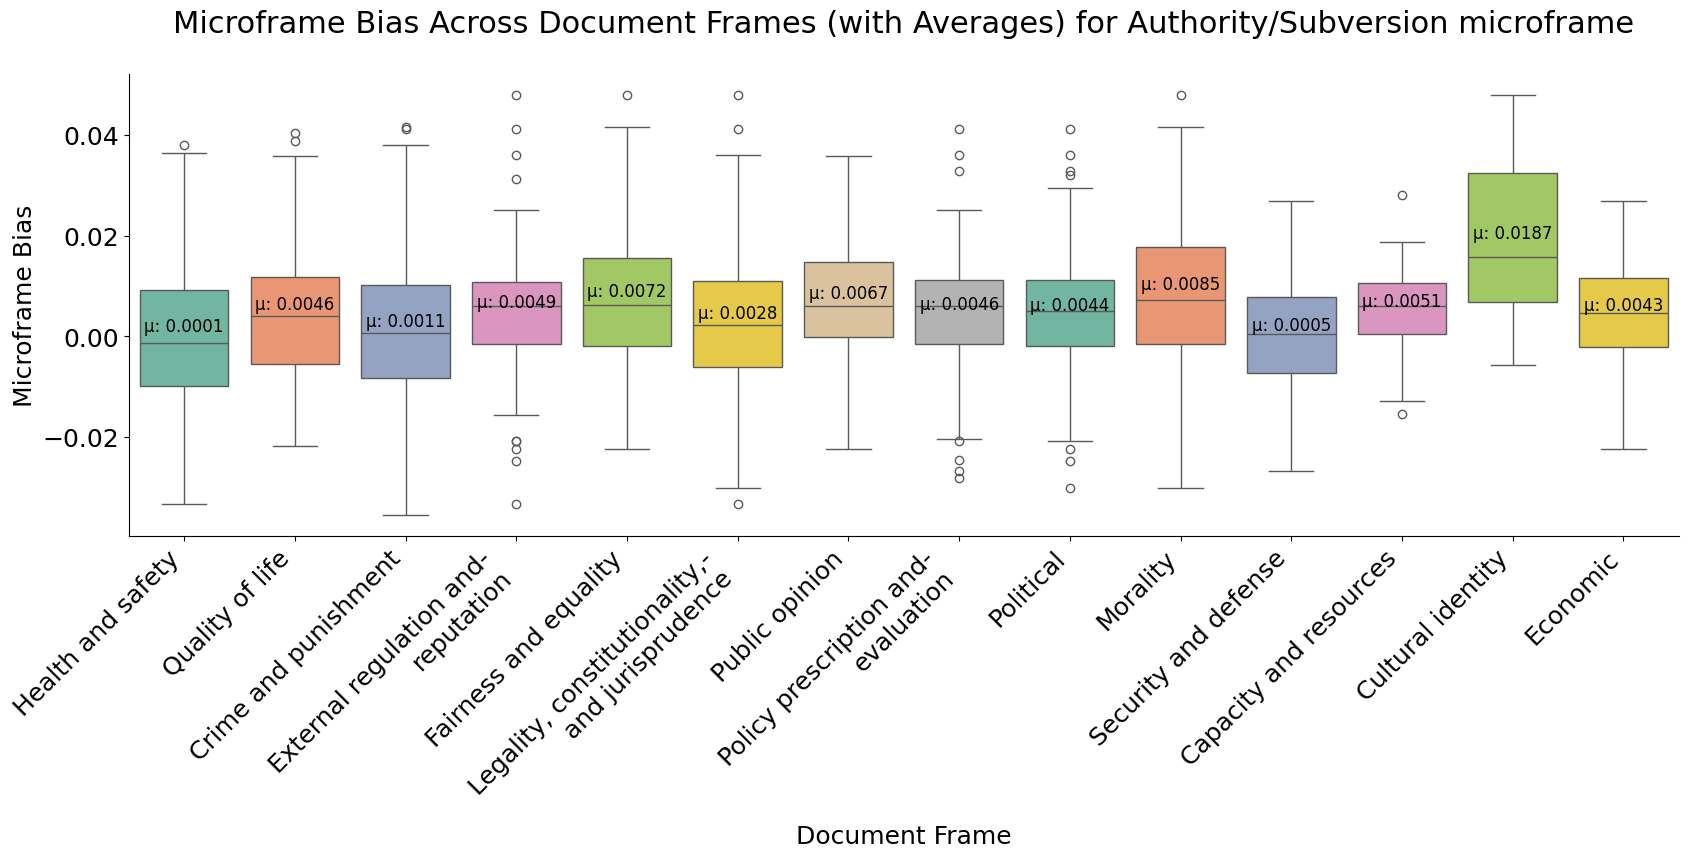

In [64]:
import textwrap

wrap_limit = 30

def wrap_with_hyphen(text, wrap_limit):
    if len(text) <= wrap_limit:
        return text
    wrapped_lines = textwrap.wrap(text, wrap_limit)
    hyphenated_text = [line + '-' if i < len(wrapped_lines) - 1 else line for i, line in enumerate(wrapped_lines)]
    return "\n".join(hyphenated_text)

def plot_bias_per_foundation(df, foundation):
    means = df.groupby('frames')[foundation + '_bias'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')
    plt.title(f'Microframe Bias Across Document Frames (with Averages) for {microframe_map[foundation]} microframe\n', fontsize=22)

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['frames'] == frame, foundation + '_bias'].values[0]
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', fontsize=12, ha='center', va='bottom', color='black')

    labels = [wrap_with_hyphen(frame_map[label.get_text()], wrap_limit) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=ticks_fontsize)

    sns.despine()

    plt.xlabel('Document Frame', fontsize=18)
    plt.ylabel('Microframe Bias', fontsize=18)
    plt.xticks(fontsize=18, rotation=45)
    plt.yticks(fontsize=18)
    plt.show()

plot_bias_per_foundation(df_article_single, 'care')
#plot_bias_per_foundation(df_article_single, 'loyalty')
plot_bias_per_foundation(df_article_single, 'authority')
#plot_bias_per_foundation(df_article_single, 'fairness')
#plot_bias_per_foundation(df_article_single, 'sanctity')

C:\Users\elias\AppData\Local\Temp\ipykernel_24872\1249800898.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


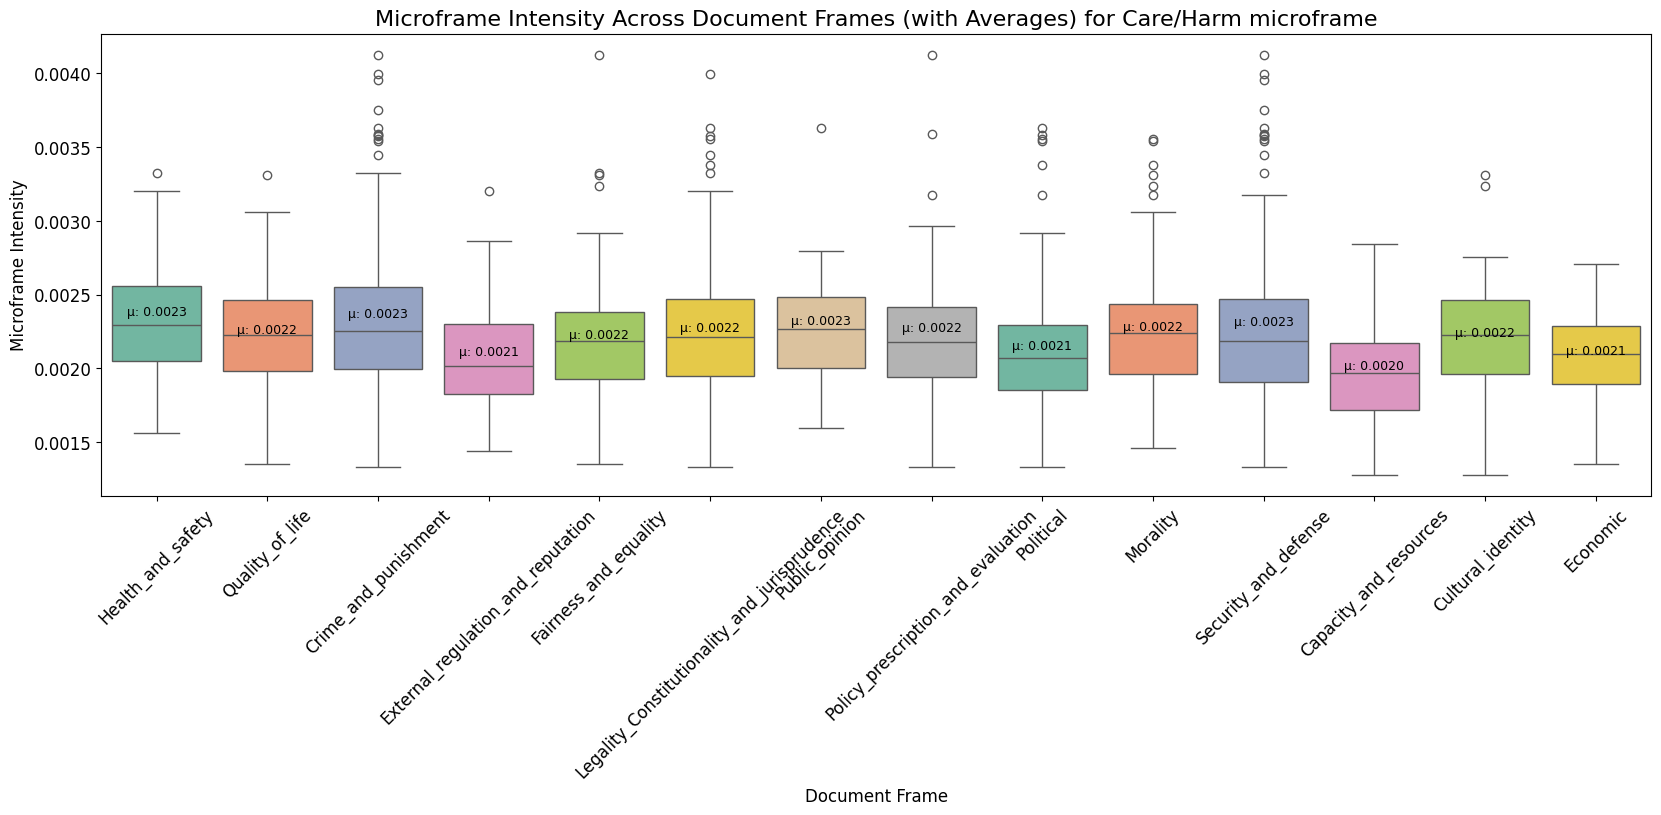

C:\Users\elias\AppData\Local\Temp\ipykernel_24872\1249800898.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


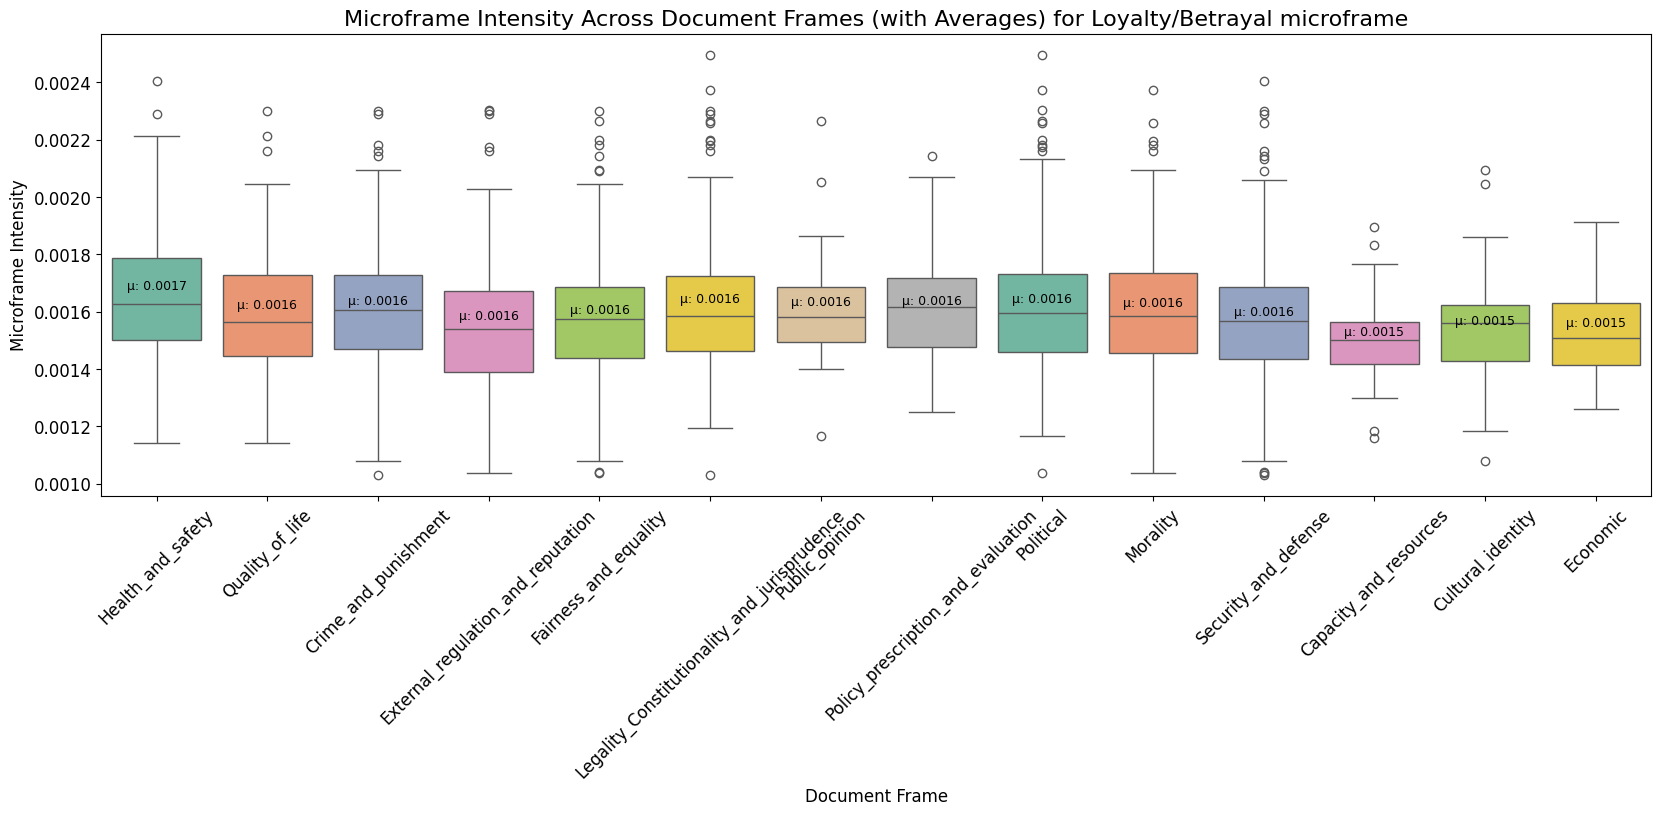

C:\Users\elias\AppData\Local\Temp\ipykernel_24872\1249800898.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


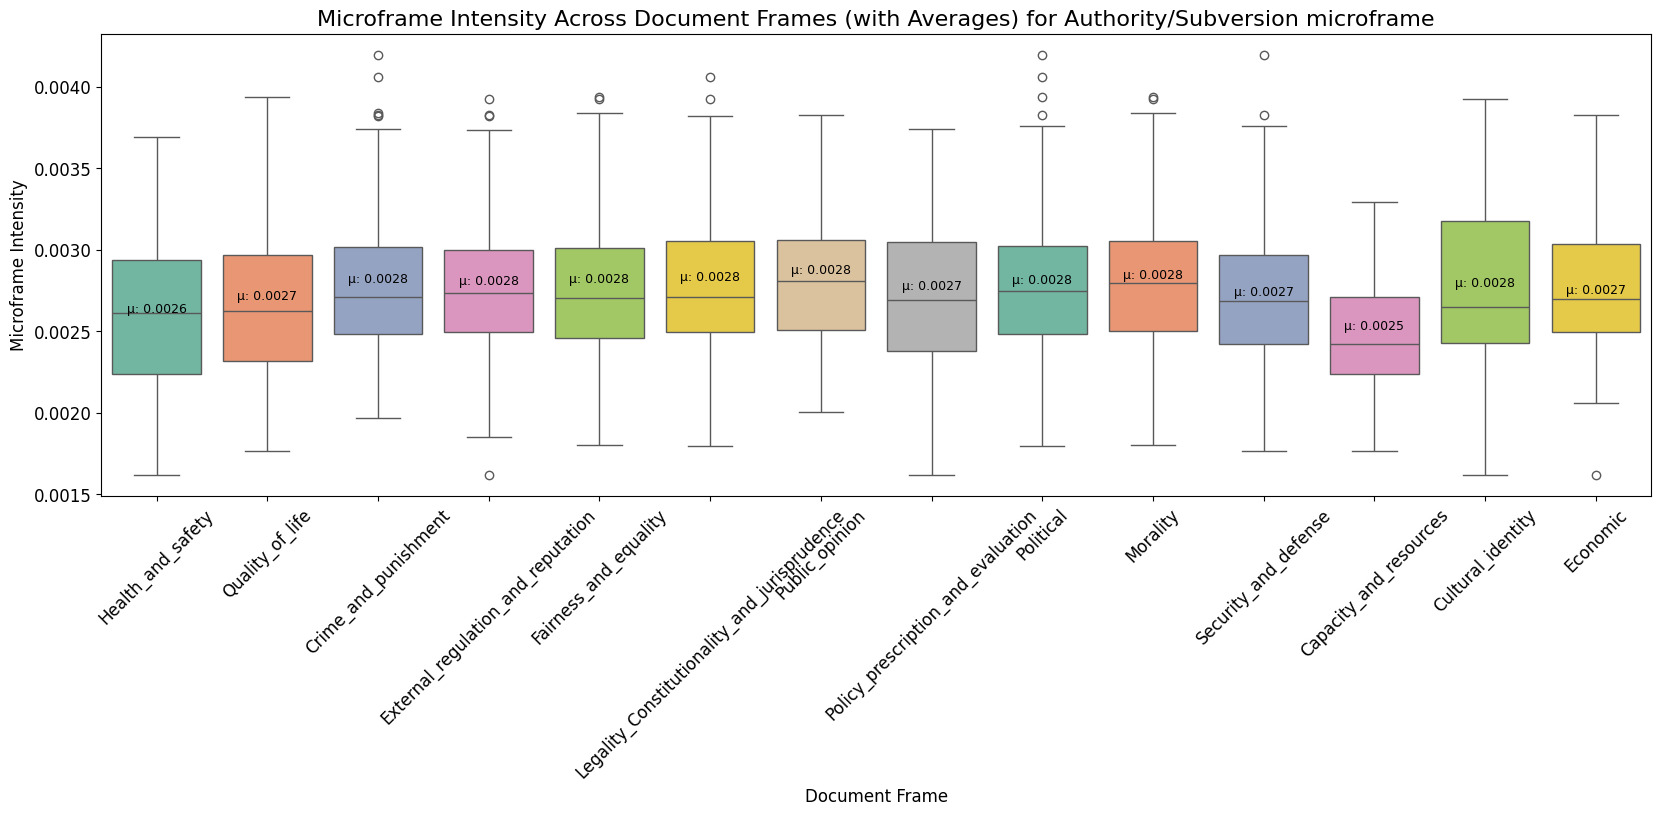

C:\Users\elias\AppData\Local\Temp\ipykernel_24872\1249800898.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


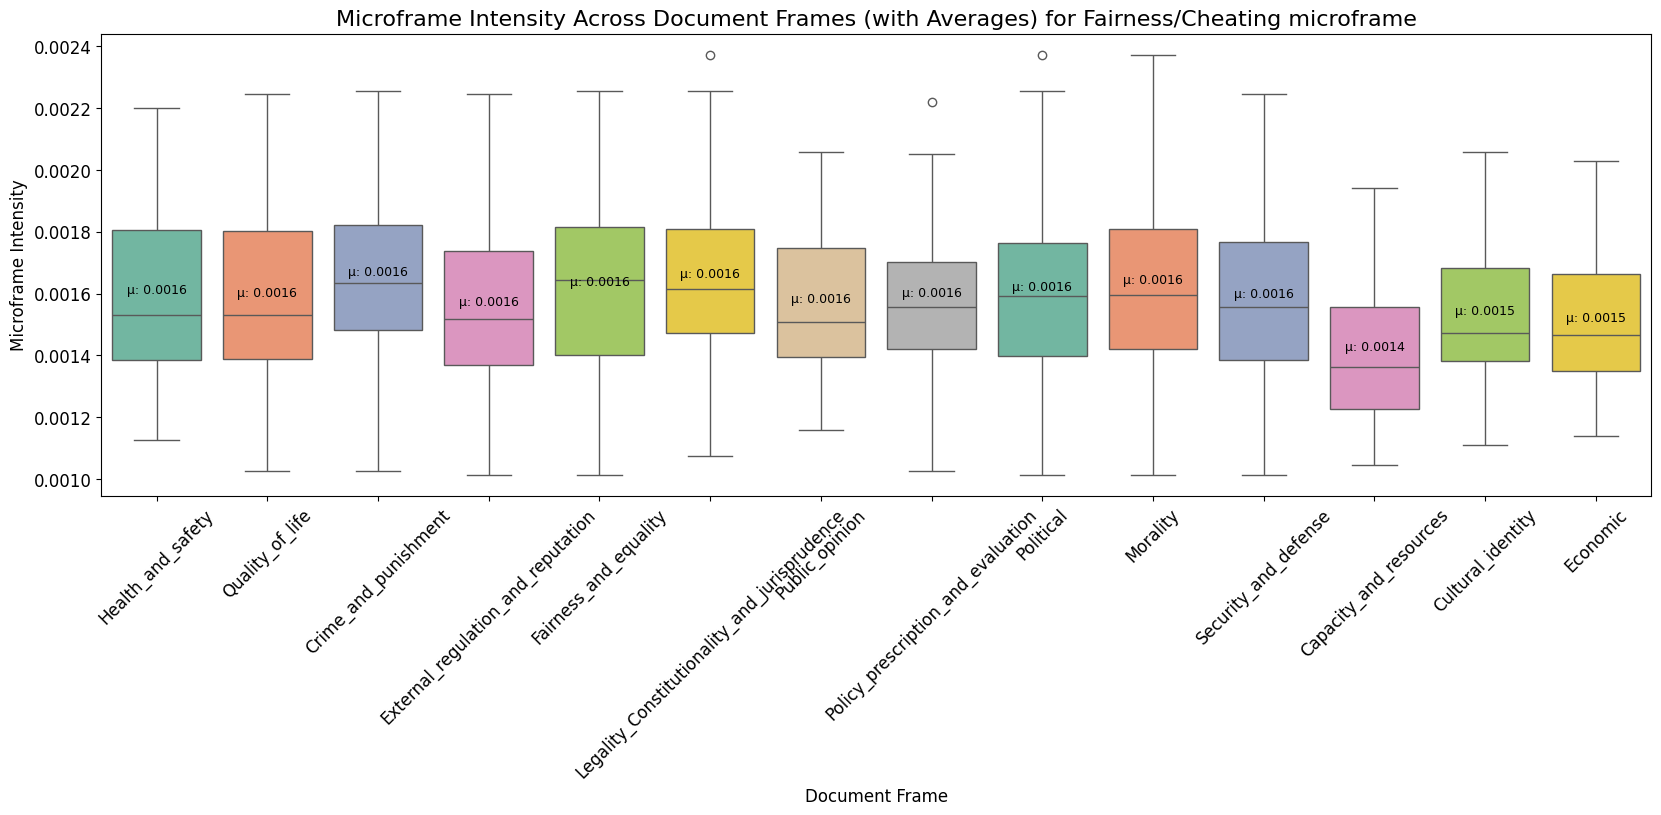

C:\Users\elias\AppData\Local\Temp\ipykernel_24872\1249800898.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


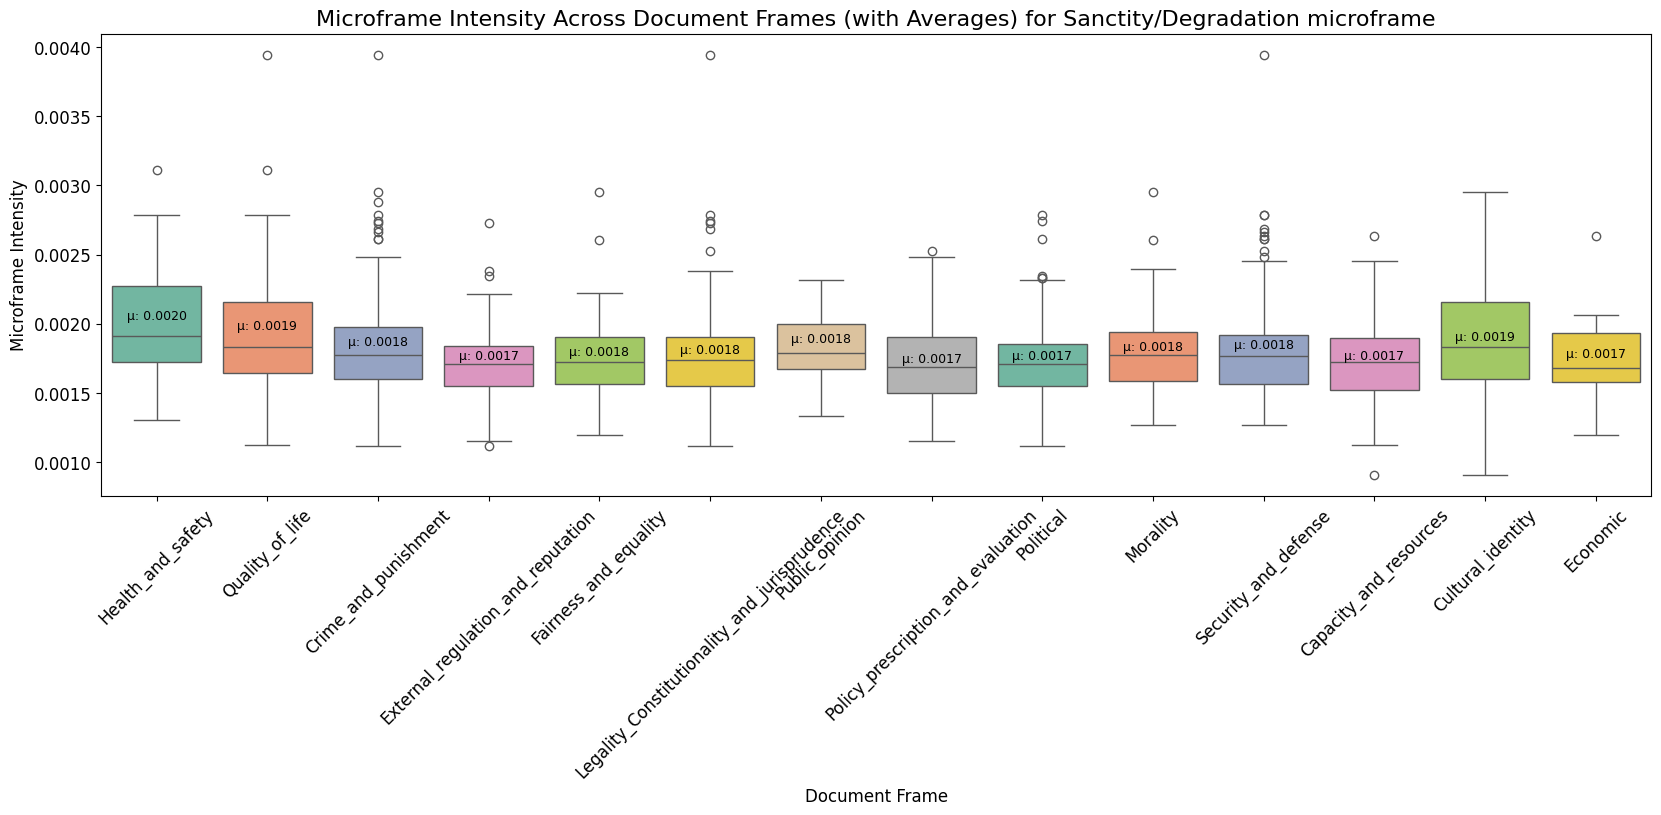

In [ ]:
def plot_intensity_per_foundation(df, foundation):
    means = df.groupby('frames')[foundation + '_intensity'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')
    plt.title(f'Microframe Intensity Across Document Frames (with Averages) for {microframe_map[foundation]} microframe', fontsize=title_fontsize)

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['frames'] == frame, foundation + '_intensity'].values[0]
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', fontsize=9, ha='center', va='bottom', color='black')

    plt.xlabel('Document Frame', fontsize=label_fontsize)
    plt.ylabel('Microframe Intensity', fontsize=label_fontsize)
    plt.xticks(fontsize=ticks_fontsize, rotation=45)
    plt.yticks(fontsize=ticks_fontsize)
    plt.show()

plot_intensity_per_foundation(df_article_single, 'care')
plot_intensity_per_foundation(df_article_single, 'loyalty')
plot_intensity_per_foundation(df_article_single, 'authority')
plot_intensity_per_foundation(df_article_single, 'fairness')
plot_intensity_per_foundation(df_article_single, 'sanctity')

### Plot Bias as X and Intensity as Y axis

In [ ]:
idx_article = 50

authority_example_value_article = {
    'x': df_article_multi.iloc[idx_article]['authority_bias'],
    'y': df_article_multi.iloc[idx_article]['authority_intensity'],
    'label': df_article_multi.iloc[idx_article]['article_id'] + " - " + df_article_multi.iloc[idx_article]['type']
}

care_example_value_article = {
    'x': df_article_multi.iloc[idx_article]['care_bias'],
    'y': df_article_multi.iloc[idx_article]['care_intensity'],
    'label': df_article_multi.iloc[idx_article]['article_id'] + " - " + df_article_multi.iloc[idx_article]['type']
}

fairness_example_value_article = {
    'x': df_article_multi.iloc[idx_article]['fairness_bias'],
    'y': df_article_multi.iloc[idx_article]['fairness_intensity'],
    'label': df_article_multi.iloc[idx_article]['article_id'] + " - " + df_article_multi.iloc[idx_article]['type']
}

loyalty_example_value_article = {
    'x': df_article_multi.iloc[idx_article]['loyalty_bias'],
    'y': df_article_multi.iloc[idx_article]['loyalty_intensity'],
    'label': df_article_multi.iloc[idx_article]['article_id'] + " - " + df_article_multi.iloc[idx_article]['type']
}

sanctity_example_value_article = {
    'x': df_article_multi.iloc[idx_article]['sanctity_bias'],
    'y': df_article_multi.iloc[idx_article]['sanctity_intensity'],
    'label': df_article_multi.iloc[idx_article]['article_id'] + " - " + df_article_multi.iloc[idx_article]['type']
}

# print full text
print("Text: ", df_article_multi.iloc[idx_article]['text'])

print("Frame Type: ", df_article_multi.iloc[idx_article]["frame_type"])

Text:  Officials Warn: Airborne Black Death Epidemic Could ‘Explode’. The bubonic plague outbreak that is taking Madagascar to its knees will more than likely last another six months. But the worst news is that the epidemic could explode anytime unleashing the sickness on the globe. At least 128 people have been killed and more than 1,300 infected by the deadlier pneumonic strain of the medieval disease. But the oncoming rainy season could see the number of those infected explode exponentially. The rainy season poses a threat to the containment of the plague because outbreaks of this magnitude often seem to be seasonal. The Foreign Office recently warned that the deadly outbreak is entering its most dangerous phase. Its website said that “outbreaks of plague tend to be seasonal and occur mainly during the rainy season.” The African island’s wet season officially began today and will last until the end of April, meaning the downward trend the plague had seen over the past few days, will

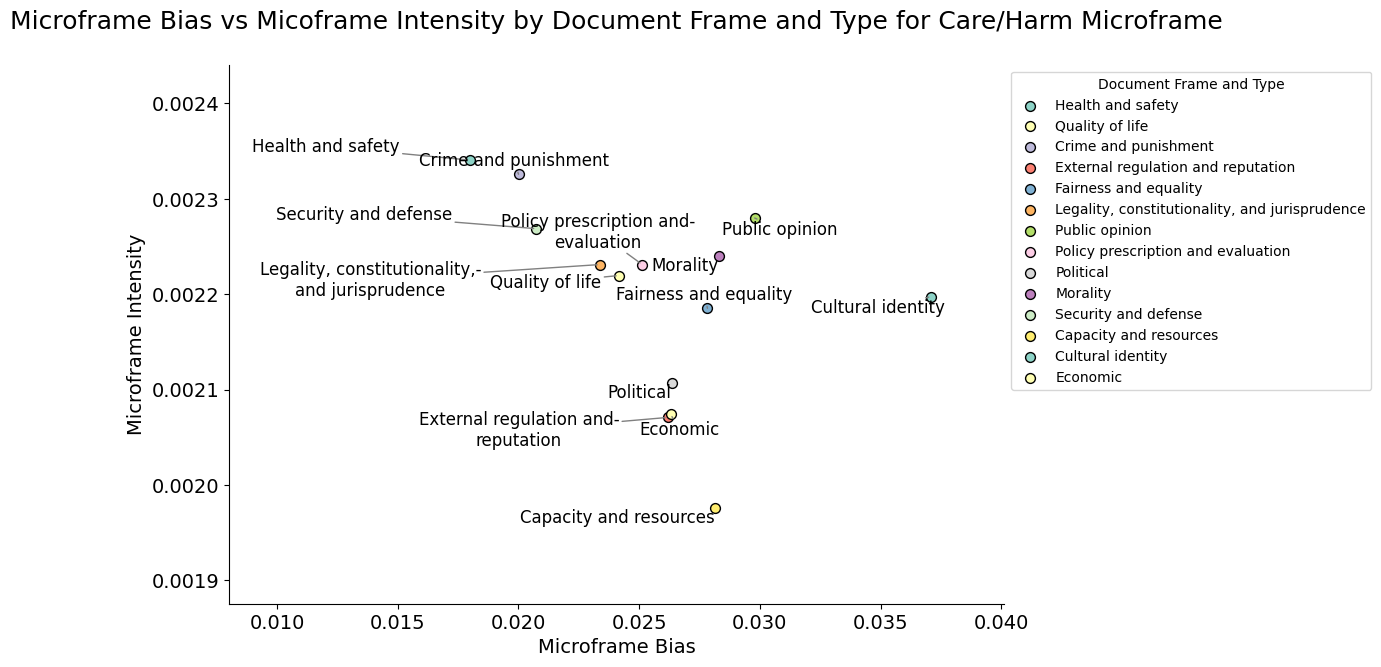

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text
import textwrap

def wrap_with_hyphen(text, wrap_limit):
    if len(text) <= wrap_limit:
        return text
    wrapped_lines = textwrap.wrap(text, wrap_limit)
    hyphenated_text = [line + '-' if i < len(wrapped_lines) - 1 else line for i, line in enumerate(wrapped_lines)]
    return "\n".join(hyphenated_text)


def plot_pair(df, pair, group_by=['frame_type'], plot_density={}, types=['opinion', 'reporting', 'satire'], example_plot_value={}):
    # Filter the DataFrame for the types we are interested in
    df_filtered = df[df['type'].isin(types)]
    
    # Set up plot
    plt.figure(figsize=(10, 7))
    
    # List to store points and their labels for later plotting
    points_with_labels = []
    texts = []
    group_colors = {}

    # Iterate over each group type
    for group_type in group_by:
        if group_type in df.columns:
            # Process each unique group within the group type
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                # Calculate average values for the pair
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()

                # Assign color for the group
                color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                group_colors[group_name] = color

                # Save the point and label for plotting
                points_with_labels.append((avg_bias, avg_intensity, group_name, color))

                # Extract bias and intensity for KDE plot
                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    # KDE plot for the group
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5)

    # Plot points and their labels
    for bias, intensity, label, color in points_with_labels:
        plt.scatter(bias, intensity, color=color, s=50, edgecolor='black', label=frame_map[label])
        
        label_wrapped = wrap_with_hyphen(frame_map[label], wrap_limit)
        text = plt.text(bias, intensity, label_wrapped, fontsize=12, ha='right')
        texts.append(text)

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")

        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        text = plt.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=8, ha='right')
        texts.append(text)

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.01, max([p[0] for p in points_with_labels]) + 0.003])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    grouping_method = ', '.join("Document Frame" if elem == "document_frame" else "Document Frame and Type" for elem in group_by)

    sns.despine()

    # Add labels and legend
    plt.xlabel(f'Microframe Bias', fontsize=14)
    plt.ylabel(f'Microframe Intensity', fontsize=14)
    plt.title(f'Microframe Bias vs Micoframe Intensity by {grouping_method} for {microframe_map[pair]} Microframe\n', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Add legend outside the plot area
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title=grouping_method, title_fontsize=10, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))

    # Show plot
    plt.show()


# Example usage:
#plot_pair(df_article_single, 'authority', group_by=['frames'], plot_density={ 'frames': False }, types=['opinion', 'reporting', 'satire']) 
plot_pair(df_article_single, 'care', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])
#plot_pair(df_article_single, 'fairness', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])
#plot_pair(df_article_single, 'loyalty', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])
#plot_pair(df_article_single, 'sanctity', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])

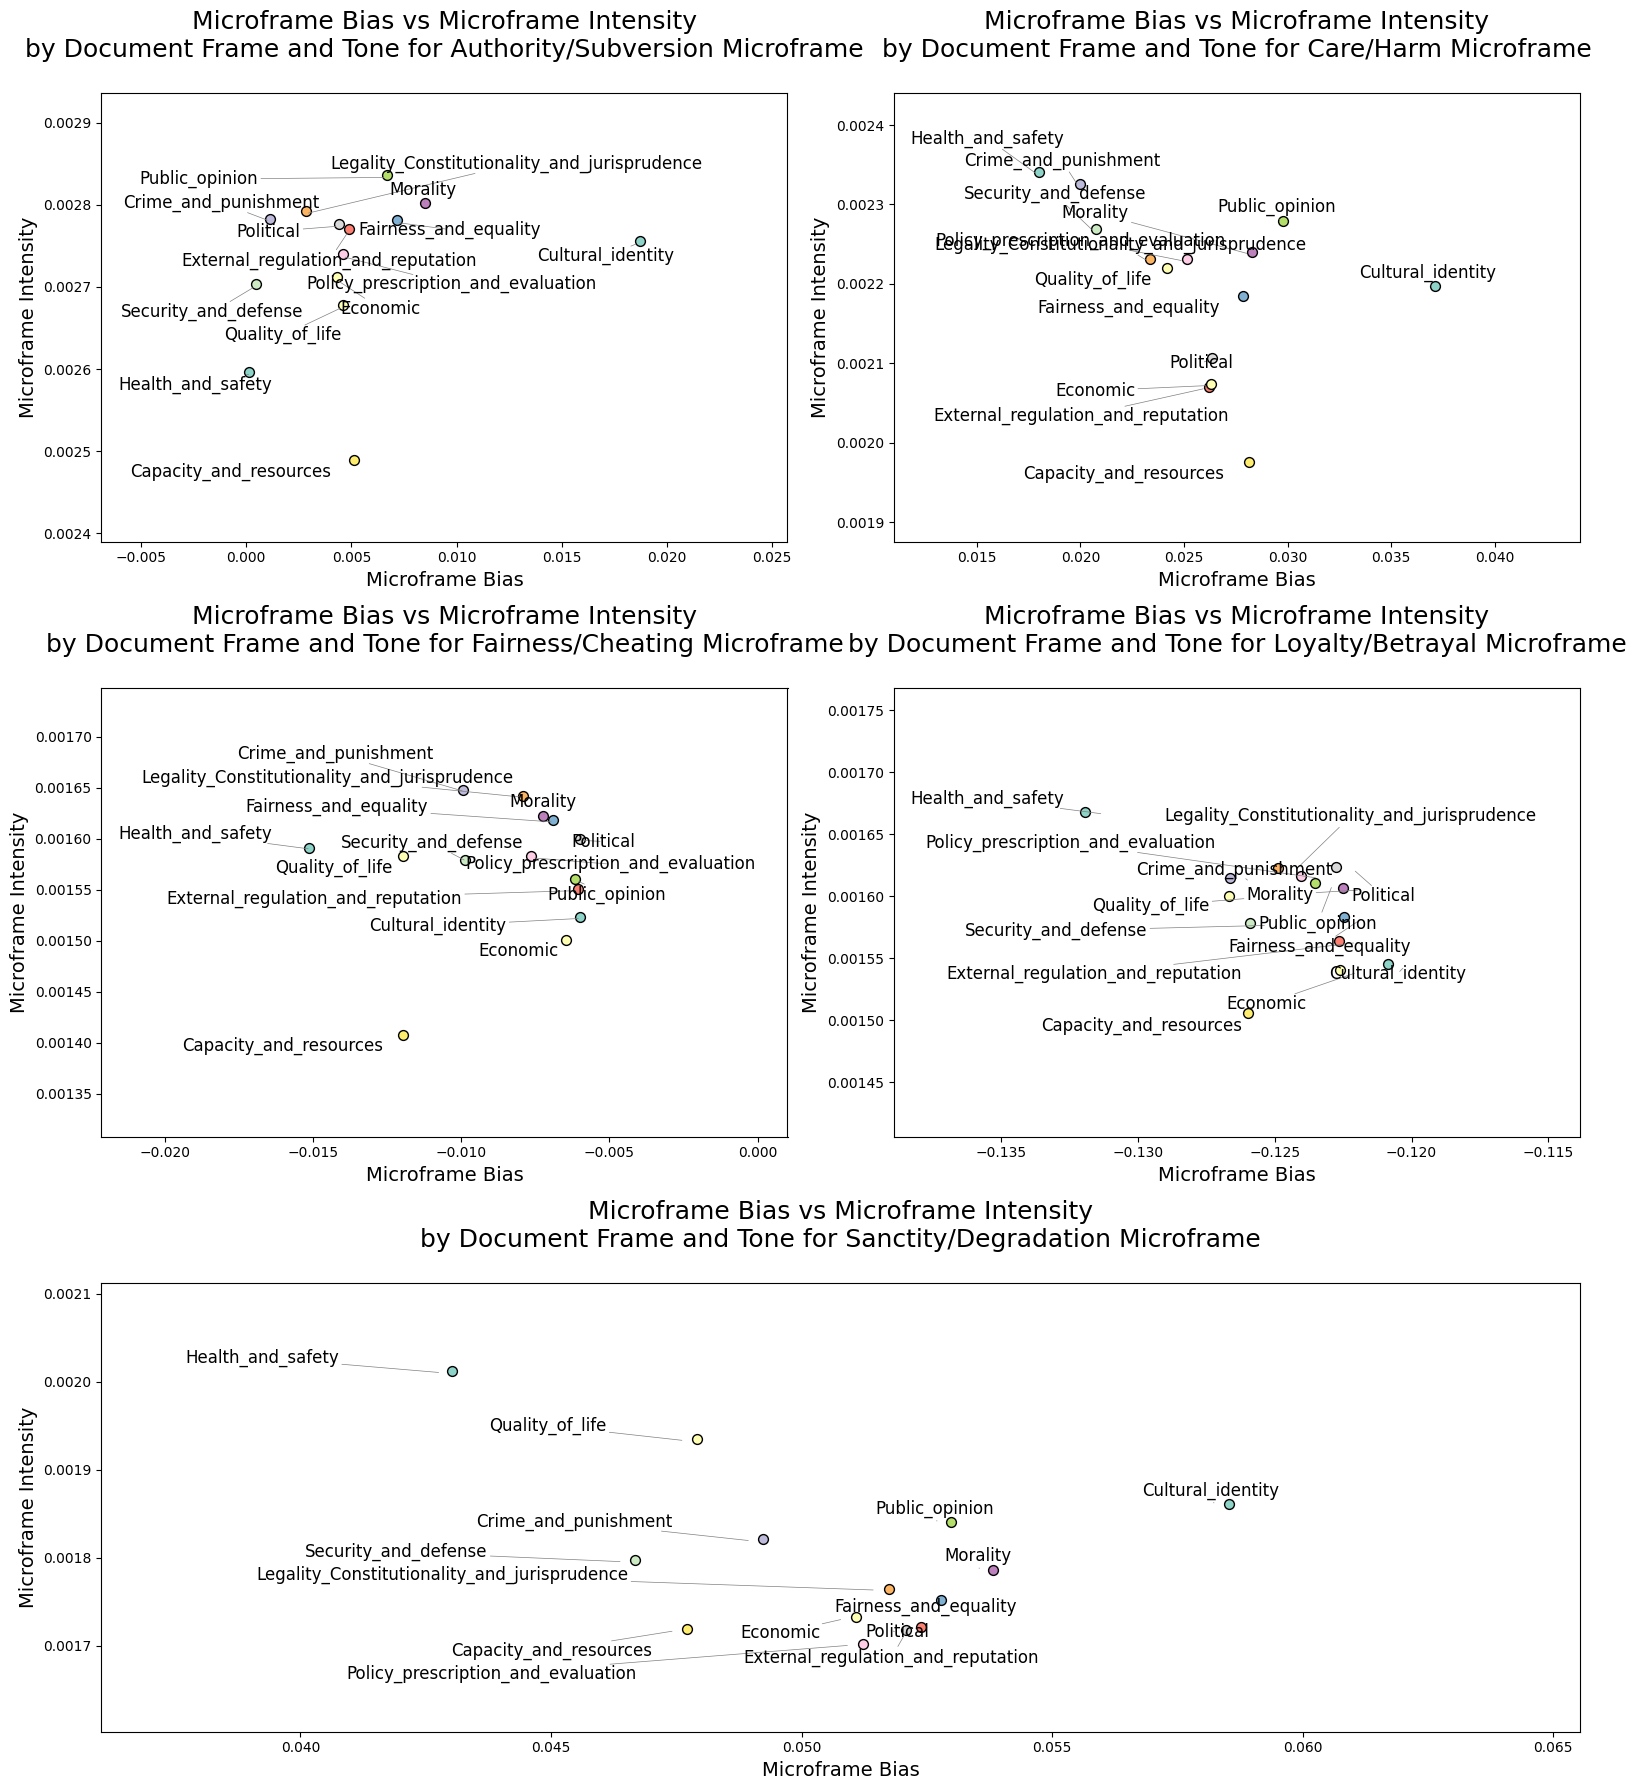

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pair(df, pair, group_by=['frame_type'], plot_density={}, types=['opinion', 'reporting', 'satire'], example_plot_value={}, ax=None):
    # Filter the DataFrame for the tones we are interested in
    df_filtered = df[df['type'].isin(types)]
    
    # Set up plot in provided axis
    if ax is None:
        ax = plt.gca()
    
    points_with_labels = []
    texts = []


    for group_type in group_by:
        if group_type in df.columns:
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()
                
                points_with_labels.append((avg_bias, avg_intensity, group_name))

                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5, ax=ax)

    for bias, intensity, label in points_with_labels:
        ax.scatter(bias, intensity, color=sns.color_palette('Set3')[points_with_labels.index((bias, intensity, label)) % len(sns.color_palette('Set3'))], s=50, edgecolor='black')
        text = ax.text(bias * 0.995, intensity * 0.999, label, fontsize=12, ha='right')
        texts.append(text)

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))
        ax.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        text = ax.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')
        texts.append(text)

    ax.set_xlim([min([p[0] for p in points_with_labels]) - 0.007, max([p[0] for p in points_with_labels]) + 0.007])
    ax.set_ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    grouping_method = ', '.join("Document Frame" if elem == "document_frame" else "Document Frame and Tone" for elem in group_by)

    ax.set_xlabel(f'Microframe Bias', fontsize=14)
    ax.set_ylabel(f'Microframe Intensity', fontsize=14)
    ax.set_title(f'Microframe Bias vs Microframe Intensity\nby {grouping_method} for {microframe_map[pair]} Microframe\n', fontsize=18)

    # Adjust text positions to avoid overlap
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

# Create a figure with 2 columns and 3 rows, but make last plot span two columns
plt.figure(figsize=(16, 18))
pairs = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']
for i, pair in enumerate(pairs):
    if i < 4:
        ax = plt.subplot(3, 2, i+1)
    else:
        ax = plt.subplot(3, 2, (i+1, i+3))  # Make the last plot span two columns
    plot_pair(df_article_single, pair, group_by=['frames'], plot_density={'frames': False}, types=['opinion', 'reporting', 'satire'], ax=ax)

plt.tight_layout()
plt.show()


### Plot Pair for single document_frame

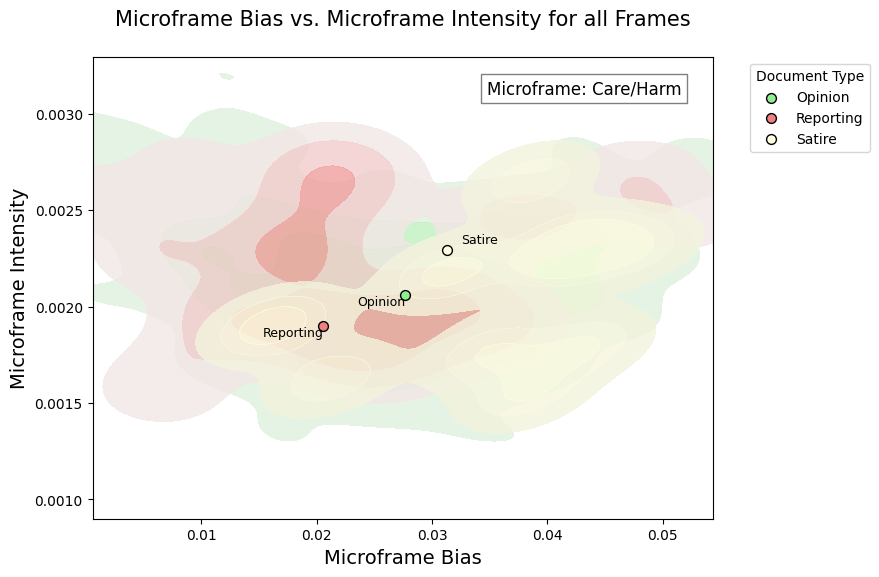

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

def get_float_mode(data):
     # Bin the data (you can adjust the number of bins as needed)
    bin_edges = np.histogram_bin_edges(data, bins=20)
    data_binned = pd.cut(data, bins=bin_edges)

    # Calculate the mode of the bins
    mode_bin = data_binned.mode()

    # Calculate the mean of the bin midpoints if there are multiple modes
    bin_midpoints = [(interval.left + interval.right) / 2 for interval in mode_bin]

    return np.mean(bin_midpoints)

def plot_pair_by_type_within_frame(
    df,
    pair,
    frames,
    plot_density=True,
    types=["opinion", "reporting", "satire"],
    example_plot_value={},
    colors={"opinion": "lightgreen", "reporting": "lightcoral", "satire": "lightyellow"},
):
    # Filter the DataFrame for the specified document frame
    df_filtered = df[df["frames"].isin(frames)]

    # Set up plot
    plt.figure(figsize=(8, 6))

    # Initialize a list to keep track of points and labels for adjustment
    points_with_labels = []
    texts = []

    # Iterate over each specified type within the document frame
    for type in types:
        type_data = df_filtered[df_filtered["type"] == type]

        if type == "opinion":
            type_label = "Opinion"
        elif type == "reporting":
            type_label = "Reporting"
        elif type == "satire":
            type_label = "Satire"

        # Calculate average values for the pair
        mode_bias = get_float_mode(type_data[f"{pair}_bias"])
        mode_intensity = get_float_mode(type_data[f"{pair}_intensity"])

        avg_bias = mode_bias
        avg_intensity = mode_intensity

        # Save the average point and label for plotting
        points_with_labels.append((avg_bias, avg_intensity, type))

        # Extract bias and intensity for KDE plot if required
        bias_values = type_data[f"{pair}_bias"]
        intensity_values = type_data[f"{pair}_intensity"]

        color = colors.get(type, "gray")  # Default to gray if type is not in the colors dictionary

        if plot_density:
            sns.kdeplot(
                x=bias_values,
                y=intensity_values,
                cmap=sns.light_palette(color, as_cmap=True),
                fill=True,
                thresh=0.1,
                levels=4,
                alpha=0.8,
                bw_adjust=0.7,
            )

        # Plot the average point and label
        plt.scatter(avg_bias, avg_intensity, color=color, s=50, edgecolor="black", zorder=5)
        texts.append(plt.text(avg_bias, avg_intensity, type_label, fontsize=9, ha="left", zorder=6))

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")
        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color="blue", s=50, edgecolor="black")
        texts.append(plt.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha="left", zorder=6))

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.02, max([p[0] for p in points_with_labels]) + 0.023])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.001, max([p[1] for p in points_with_labels]) + 0.001])

    # Add labels and legend
    plt.xlabel("Microframe Bias", fontsize=14)
    plt.ylabel("Microframe Intensity", fontsize=14)

    joined_frames = ", ".join(frame_map[frame] for frame in frames)

    plt.title(f"Microframe Bias vs. Microframe Intensity for all Frames\n", fontsize=15)

    # Add a text box for the pair
    plt.gca().text(
        0.95,
        0.95,
        f"Microframe: {microframe_map[pair]}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    plt.legend(
        title="Document Type",
        labels=["Opinion", "Reporting", "Satire"],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    # Adjust text to prevent overlap
    adjust_text(texts)

    # Show plot
    plt.show()

# Example usage:
plot_pair_by_type_within_frame(
    df_article_single,
    "care",
    frames=list(df_article_single["frames"].unique()),
    types=["opinion", "reporting", "satire"],
)


### Plot Pair for single document_frame for all foundations in a single plot

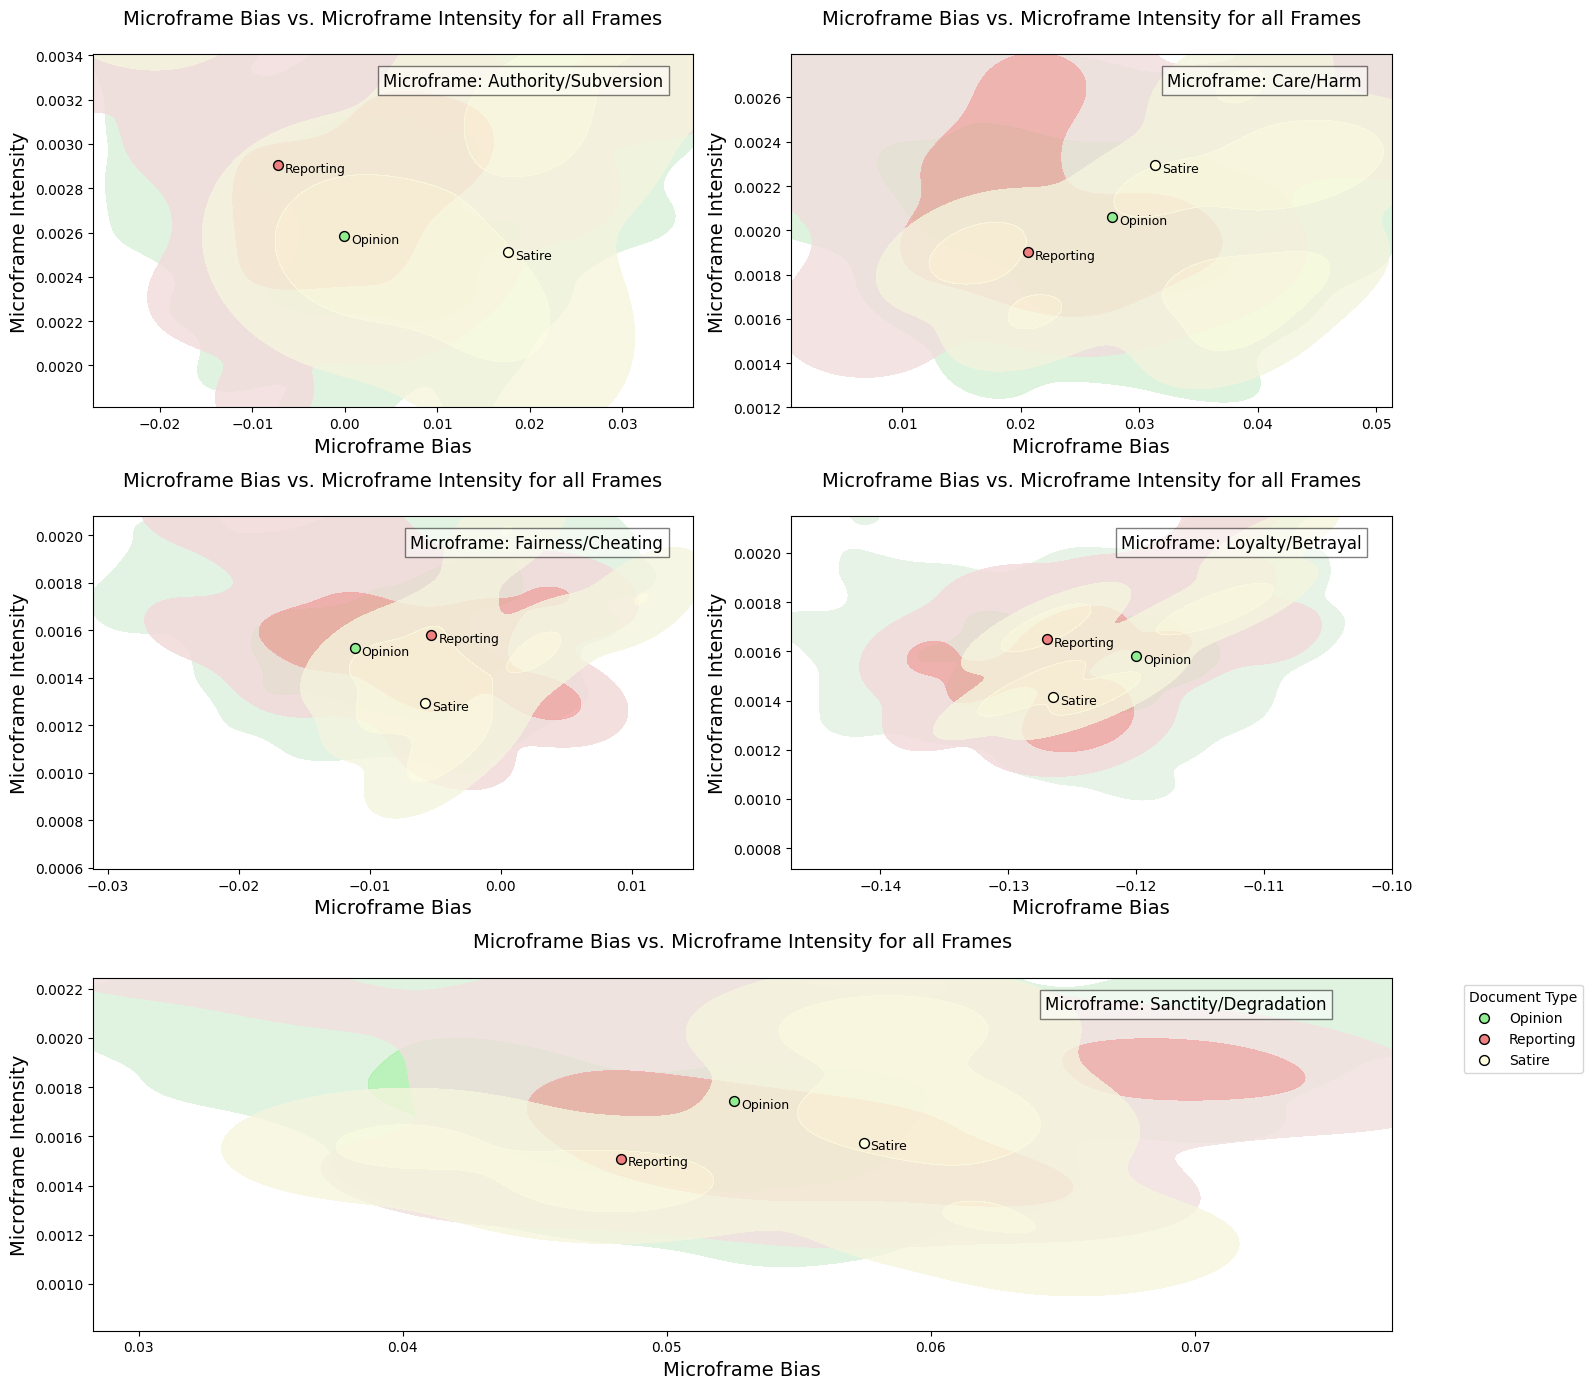

In [99]:
from matplotlib import gridspec
from matplotlib import transforms

def plot_pairs_by_type_within_frame(df, pairs, frames, plot_density=True, types=['opinion', 'reporting', 'satire'], example_plot_values={}, colors={"opinion": "lightgreen", "reporting": "lightcoral", "satire": "lightyellow"}):
    # Set up the subplot grid
    fig = plt.figure(figsize=(16, 14))
    gs = gridspec.GridSpec(3, 2)

    # Define subplot placement
    axes = []
    for i in range(4):
        row = i // 2
        col = i % 2
        axes.append(fig.add_subplot(gs[row, col]))
    # Add the last subplot which spans both columns in the last row
    axes.append(fig.add_subplot(gs[2, :]))


    # Iterate over each pair and plot
    for i, pair in enumerate(pairs):
        ax = axes[i]
        # Filter the DataFrame for the specified document frame
        df_filtered = df[df['frames'].isin(frames)]

        # Initialize a list to keep track of points for plot limits
        points_with_labels = []

        # Iterate over each specified type within the document frame
        for type in types:
            type_data = df_filtered[df_filtered['type'] == type]

            if type == "opinion":
                type_label = "Opinion"
            elif type == "reporting":
                type_label = "Reporting"
            elif type == "satire":
                type_label = "Satire"


            # Calculate average values for the pair
            mode_bias = get_float_mode(type_data[f"{pair}_bias"])
            mode_intensity = get_float_mode(type_data[f"{pair}_intensity"])

            avg_bias = mode_bias
            avg_intensity = mode_intensity

            # Save the average point and label for plotting
            points_with_labels.append((avg_bias, avg_intensity, type))

            # Extract bias and intensity for KDE plot if required
            bias_values = type_data[f'{pair}_bias']
            intensity_values = type_data[f'{pair}_intensity']

            color = colors.get(type, 'gray')  # Default to gray if type is not in the colors dictionary

            if plot_density:
                sns.kdeplot(
                    x=bias_values,
                    y=intensity_values,
                    cmap=sns.light_palette(color, as_cmap=True),
                    fill=True,
                    levels=3,
                    alpha=0.8,
                    bw_adjust=0.8,
                    ax=ax
                )

            # Plot the average point and label
            ax.scatter(avg_bias, avg_intensity, color=color, s=50, edgecolor='black', zorder=5)
            offset = transforms.ScaledTranslation(5/72, -5/72, plt.gcf().dpi_scale_trans)
            ax.text(avg_bias, avg_intensity, type_label, fontsize=9, ha='left', transform=ax.transData + offset, zorder=6) 

        example_plot_value = example_plot_values.get(pair, {})
        if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
            # Plot the example point
            ax.scatter(example_plot_value["x"], example_plot_value["y"], color='blue', s=50, edgecolor='black')
            ax.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, transform=ax.transData + offset, zorder=6, ha='left')

            points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Adjusting plot limits to fit all points comfortably
        ax.set_xlim([min([p[0] for p in points_with_labels]) - 0.02, max([p[0] for p in points_with_labels]) + 0.02])
        ax.set_ylim([min([p[1] for p in points_with_labels]) - 0.0007, max([p[1] for p in points_with_labels]) + 0.0005])

        # Add a text box for the pair
        ax.text(0.95, 0.95, f"Microframe: {microframe_map[pair]}",
                   transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(facecolor='white', alpha=0.5))

        # Add labels and title
        ax.set_xlabel('Microframe Bias', fontsize=14)
        ax.set_ylabel('Microframe Intensity', fontsize=14)
        ax.set_title(f'Microframe Bias vs. Microframe Intensity for all Frames\n', fontsize=14)

    plt.legend(title='Document Type', labels=['Opinion', 'Reporting', 'Satire'], bbox_to_anchor=(1.05, 1), loc='upper left')
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
pairs = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']
#example_plot_values = {
#    'authority': authority_example_value_article,
#    'care': care_example_value_article,
#    'fairness': fairness_example_value_article,
#    'loyalty': loyalty_example_value_article,
#    'sanctity': sanctity_example_value_article
#}
plot_pairs_by_type_within_frame(df_article_single, pairs, frames=list(df_article_single["frames"].unique()), types=['opinion', 'reporting', 'satire'])

### Microframe Bias and Intensity Shift per Word

#### Prepare the data

In [106]:
contributions_file_name = "frameaxis_semeval_mft_experiment_contributions"

In [107]:
import pandas as pd
import json

In [108]:
# read data\frameaxis\mfc\frameaxis_mft_contributions.pkl

df_wc = pd.read_pickle(f"../../data/frameaxis/semeval/{contributions_file_name}.pkl")

df_wc.set_index('article_id', inplace=True)

In [109]:
frame_columns = ['Capacity_and_resources', 'Crime_and_punishment', 'Cultural_identity', 'Economic',
                 'External_regulation_and_reputation', 'Fairness_and_equality', 'Health_and_safety',
                 'Legality_Constitutionality_and_jurisprudence', 'Morality', 'Policy_prescription_and_evaluation',
                 'Political', 'Public_opinion', 'Quality_of_life', 'Security_and_defense']

# Create an empty list to store the new rows
new_rows = []

# Iterate through each row in the dataframe
for idx, row in df_wc.iterrows():
    # For each row, iterate through the frame columns and check if they have a value of 1
    for frame in frame_columns:
        if row[frame] == 1:
            # Create a new row with the 'frames' column set to the current frame
            new_row = row.drop(frame_columns).copy()
            new_row['frames'] = frame
            new_rows.append(new_row)

# Create a new dataframe from the new rows
new_df = pd.DataFrame(new_rows)

In [110]:
df_wc = new_df

In [111]:
# concat primary_tone and document_frame to create frame_tone
df_wc["frame_type"] = df_wc["frames"] + " - " + df_wc["type"]

df_wc["type"] = pd.Categorical(df_wc["type"], categories=["reporting", "opinion", "satire", "nan"], ordered=True)

In [112]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [113]:
# loop over df and find immigration as key in word_contributions col which is a list
from collections import Counter 

word_blacklist=['"', '“', '“', '”', '’', '‘']
lemmatized_blacklist = [lemmatizer.lemmatize(word) for word in word_blacklist]

In [114]:
import re

def clean_and_lemmatize_word(word):
    cleaned_word = word.lower()
    # Remove all non-alphanumeric characters except for spaces
    # cleaned_word = re.sub(r'[^\w\s]', '', word)
    # Lemmatize the cleaned word
    lemmatized_word = lemmatizer.lemmatize(cleaned_word)
    return lemmatized_word

def lemmatize_and_filter_contributions(contributions):
    filtered_contributions = []
    for contribution in contributions:
        # Clean and lemmatize the 'word' key in each dictionary
        cleaned_lemmatized_word = clean_and_lemmatize_word(contribution['word'])
        
        # Check if the cleaned and lemmatized word is not in the blacklisted words
        if cleaned_lemmatized_word and cleaned_lemmatized_word not in lemmatized_blacklist:
            contribution['word'] = cleaned_lemmatized_word
            filtered_contributions.append(contribution)

    return filtered_contributions

df_wc['word_contributions'] = df_wc['word_contributions'].apply(lemmatize_and_filter_contributions)

In [115]:
# Function to search for a word in the word_contributions column
def search_word(word, df):
    results = []
    
    for idx, row in df.iterrows():        
        for i, contribution in enumerate(row['word_contributions']):
            if contribution['word'] == word:
                if i > 0 and i < len(row['word_contributions']) - 1:
                    results.append((row['word_contributions'][i-1]['word'], contribution['word'], row['word_contributions'][i+1]['word']))
                elif i < len(row['word_contributions']) - 1:
                    results.append((None, contribution['word'], row['word_contributions'][i+1]['word']))
                else:
                    results.append((None, contribution['word'], None))
    
    return results

In [116]:
# Example search
search_word('”', df_wc)

[]

#### Replace and combine

In [117]:
curated_list = {
    "yellow vests": ("yellow", "vest"),
    "la salette": ("la", "salette"),
    "la stampa": ("la", "stampa"),  
    "la times": ("la", "time"),
    "la raza": ("la", "raza"),
    "las vegas": ("la", "vega"),
    "la cruz": ("la", "cruz"),
    "la frontera": ("la", "frontera"),
    }

In [118]:
from collections import defaultdict


# Function to lemmatize word
def lemmatize_word(word):
    return lemmatizer.lemmatize(word)

# Function to replace variations and combine words
def replace_and_combine(word_contributions, curated_list):
    combined_word_contributions = []
    i = 0
    while i < len(word_contributions):
        combined = False
        
        for key, (first_word, second_word) in curated_list.items():
            if (i + 1 < len(word_contributions) and
                lemmatize_word(word_contributions[i]['word']) == first_word and
                lemmatize_word(word_contributions[i + 1]['word']) == second_word):
                
                combined_word = key
                combined_values = defaultdict(list)
                
                for k, v in word_contributions[i].items():
                    if k != 'word':
                        combined_values[k].append(v)
                
                for k, v in word_contributions[i + 1].items():
                    if k != 'word':
                        combined_values[k].append(v)
                
                combined_entry = {'word': combined_word}
                for k, v in combined_values.items():
                    combined_entry[k] = sum(v) / len(v)
                
                combined_word_contributions.append(combined_entry)
                i += 2  # Skip the next word as it is combined
                combined = True
                break
        
        if not combined:
            combined_word_contributions.append(word_contributions[i])
            i += 1
    
    return combined_word_contributions


df_wc['word_contributions'] = df_wc['word_contributions'].apply(lambda x: replace_and_combine(x, curated_list))

In [119]:
search_word('la', df_wc)

[('daily', 'la', 'nuova'),
 ('daily', 'la', 'nuova'),
 ('daily', 'la', 'nuova'),
 ('robert', 'la', 'best'),
 ('robert', 'la', 'best'),
 ('robert', 'la', 'best'),
 ('robert', 'la', 'best'),
 ('robert', 'la', 'best'),
 ('robert', 'la', 'best'),
 ('robert', 'la', 'best'),
 ('aka', 'la', 'flaca'),
 ('aka', 'la', 'flaca'),
 ('aka', 'la', 'flaca'),
 ('aka', 'la', 'flaca')]

#### Calculate Bias and Intensity shift

In [120]:
group_by_col = "frame_type"

In [121]:
def calculate_bias_shifts(data):
    # Initialize a dictionary to hold cumulative scores and counts
    contributions = {}
    total_counts = {'authority': 0, 'care': 0, 'fairness': 0, 'loyalty': 0, 'sanctity': 0}

    # Helper function to find the base word if it exists in the contributions
    def find_base_word(word):
        words = word.split()
        if len(words) > 1:
            base_word = words[-1]
            for existing_word in contributions:
                if existing_word.endswith(base_word):
                    return existing_word
        return None

    # Loop through each row's contribution data
    for contributions_list in data:
        for word_data in contributions_list:
            word = word_data['word']
            base_word = find_base_word(word)
            if base_word:
                word = base_word
            if word not in contributions:
                contributions[word] = {
                    'authority': {'values': [], 'sum': 0, 'count': 0},
                    'care': {'values': [], 'sum': 0, 'count': 0},
                    'fairness': {'values': [], 'sum': 0, 'count': 0},
                    'loyalty': {'values': [], 'sum': 0, 'count': 0},
                    'sanctity': {'values': [], 'sum': 0, 'count': 0}
                }
            # Append the bias values for each microframe and update sum and count
            for frame in ['authority', 'care', 'fairness', 'loyalty', 'sanctity']:
                bias_value = word_data.get(frame, 0)
                if bias_value != 0:  # Only count non-zero contributions
                    contributions[word][frame]['values'].append(bias_value)
                    contributions[word][frame]['sum'] += bias_value
                    contributions[word][frame]['count'] += 1
                    total_counts[frame] += 1

    # Calculate averages and prepare output with sum and count
    results = {}
    for word, frames in contributions.items():
        results[word] = {}
        for frame, details in frames.items():
            if total_counts[frame] > 0:  # Avoid division by zero
                avg = details['sum'] / total_counts[frame]
            else:
                avg = 0
            results[word][frame] = {
                'average': avg,
                'sum': details['sum'],
                'count': details['count']
            }

    return results

# Apply the function to each group of document frame
bias_shift_grouped = df_wc.groupby(group_by_col)['word_contributions'].apply(calculate_bias_shifts)

In [122]:
data = []
for (doc_frame, word), biases in bias_shift_grouped.items():
    # if shift type = float print
    if isinstance(biases, float):
        # ignore
        continue

    for microframe, bias in biases.items():
        data.append({
            group_by_col: doc_frame,
            'word': word,
            'microframe': microframe,
            'bias_shift': bias["average"],
            'bias_sum': bias["sum"],
            'bias_count': bias["count"]
        })

df_bias = pd.DataFrame(data)

In [123]:
words = df_bias["word"].value_counts()

In [124]:
# find all words with "obama" in it
words[words.index.str.contains("obama")]

word
obama     155
obamas     45
obamaa     15
Name: count, dtype: int64

In [125]:
# Microframe lists
microframe_data = {
    'authority_bias_background': [],
    'care_bias_background': [],
    'fairness_bias_background': [],
    'loyalty_bias_background': [],
    'sanctity_bias_background': []
}

# Function to parse contributions and accumulate values for each microframe
def accumulate_contributions(row):
    for contribution in row:
        for frame, value in contribution.items():
            frame = f"{frame}_bias_background"
            if frame in microframe_data:
                microframe_data[frame].append(value)

# Process each row
df_wc['word_contributions'].apply(accumulate_contributions)

# Calculate the mean for each microframe and store in a dictionary
background_biases = {frame: sum(values) / len(values) for frame, values in microframe_data.items() if values}

# Creating the DataFrame of background biases
df_background_bias = pd.DataFrame(list(background_biases.items()), columns=['microframe', 'background_bias'])

# T the df, drop first row and first col
df_background_bias = df_background_bias.T
df_background_bias.columns = df_background_bias.iloc[0]
df_background_bias = df_background_bias[1:]

In [126]:
df_background_bias

microframe      authority_bias_background care_bias_background  \
background_bias                  0.001507             0.025722   

microframe      fairness_bias_background loyalty_bias_background  \
background_bias                -0.004285               -0.131417   

microframe      sanctity_bias_background  
background_bias                 0.055329

In [127]:
def calculate_intensity_shifts(group, background_biases):
    contributions = {}
    total_counts = {'authority': 0, 'care': 0, 'fairness': 0, 'loyalty': 0, 'sanctity': 0}

    # Loop through each entry in the group
    for word_contributions in group:
        for word_data in word_contributions:
            word = word_data['word']
            if word not in contributions:
                contributions[word] = {
                    'authority': {'values': [], 'sum': 0, 'count': 0},
                    'care': {'values': [], 'sum': 0, 'count': 0},
                    'fairness': {'values': [], 'sum': 0, 'count': 0},
                    'loyalty': {'values': [], 'sum': 0, 'count': 0},
                    'sanctity': {'values': [], 'sum': 0, 'count': 0}
                }
            # Calculate the intensity shift for each microframe and append
            for frame in ['authority', 'care', 'fairness', 'loyalty', 'sanctity']:
                ca_w = word_data.get(frame, 0)
                Bf = background_biases.get(f'{frame}_bias_background', 0)
                if ca_w != 0:  # Only consider non-zero contributions for calculating
                    shift = (ca_w - Bf) ** 2
                    contributions[word][frame]['values'].append(shift)
                    contributions[word][frame]['sum'] += shift
                    contributions[word][frame]['count'] += 1
                    total_counts[frame] += 1

    # Calculate the normalized intensity for each word based on the total counts of each frame
    results = {}
    for word, frames in contributions.items():
        results[word] = {}
        for frame, frame_details in frames.items():
            if frame_details['count'] > 0:
                average = frame_details['sum'] / total_counts[frame]
            else:
                average = 0
            results[word][frame] = {
                'average': average,
                'sum': frame_details['sum'],
                'count': frame_details['count']
            }

    return results

# Apply the function for each document frame group
intensity_shift_grouped = df_wc.groupby(group_by_col)['word_contributions'].apply(lambda x: calculate_intensity_shifts(x, background_biases))

In [128]:
data = []
for (doc_frame, word), intensities in intensity_shift_grouped.items():
    # if shift type = float print
    if isinstance(intensities, float):
        # ignore
        continue

    for microframe, shift in intensities.items():
        data.append({
            group_by_col: doc_frame,
            'word': word,
            'microframe': microframe,
            'intensity_shift': shift["average"],
            'intensity_sum': shift["sum"],
            'intensity_count': shift["count"]
        })

df_intensities = pd.DataFrame(data)

In [129]:
df_intensities

frame_type         word microframe  \
0       Capacity_and_resources - opinion      popular  authority   
1       Capacity_and_resources - opinion      popular       care   
2       Capacity_and_resources - opinion      popular   fairness   
3       Capacity_and_resources - opinion      popular    loyalty   
4       Capacity_and_resources - opinion      popular   sanctity   
...                                  ...          ...        ...   
707525     Security_and_defense - satire  unexplained  authority   
707526     Security_and_defense - satire  unexplained       care   
707527     Security_and_defense - satire  unexplained   fairness   
707528     Security_and_defense - satire  unexplained    loyalty   
707529     Security_and_defense - satire  unexplained   sanctity   

        intensity_shift  intensity_sum  intensity_count  
0          7.636643e-08       0.000781                2  
1          5.077380e-07       0.005172                2  
2          2.470384e-07       0.002524                2  
3          4.260720e-07       0.004352                2  
4          3.063535e-07       0.003136                2  
...                 ...            ...              ...  
707525     3.944593e-06       0.004047                1  
707526     2.750699e-06       0.002866                1  
707527     1.783557e-07       0.000186                1  
707528     1.244453e-06       0.001284                1  
707529     5.975298e-06       0.006226                1  

[707530 rows x 6 columns]

In [130]:
import matplotlib.pyplot as plt

In [131]:
# calculate target specific background corpus bias
def get_background_word_shift_bias(df_bias, group_by_col="frame_type"):
    # Get unique frames from the grouping column
    frames = df_bias[group_by_col].unique()

    # Initialize an empty DataFrame to store the background biases
    background_biases = pd.DataFrame()

    # Calculate background biases for each word not in the same document frame
    for doc_frame in frames:
        # Filter out data from the current document frame
        df_background = df_bias[df_bias[group_by_col] != doc_frame]

        full_grouped = df_background.groupby('microframe')
        count_data = full_grouped['bias_count'].sum().reset_index(name='count')
        
        # Group by word and microframe and calculate cumulative sum and count
        grouped_data = df_background.groupby(['word', 'microframe'])
        sum_data = grouped_data['bias_sum'].sum().reset_index(name='sum')

        # Merge sum and count data
        merged_data = pd.merge(sum_data, count_data, on=['microframe'])

        # Calculate the mean bias
        merged_data['bias_background'] = merged_data['sum'] / merged_data['count']
        
        # Assign the current document frame to which this background data applies
        merged_data[group_by_col] = doc_frame
        
        # Append the calculated background means to the overall DataFrame
        background_biases = pd.concat([background_biases, merged_data], ignore_index=True)

    # Select required columns to match the output structure
    background_biases = background_biases[['word', 'microframe', 'bias_background', group_by_col]]

    return background_biases

In [132]:
df_background_shift_bias = get_background_word_shift_bias(df_bias, group_by_col=group_by_col)

In [133]:
df_background_shift_bias[(df_background_shift_bias["word"] == "welcome") & (df_background_shift_bias[group_by_col] == "Political")]

Empty DataFrame
Columns: [word, microframe, bias_background, frame_type]
Index: []

In [134]:
df_bias[(df_bias["word"] == "welcome") & (df_bias[group_by_col] == "Economic")]

Empty DataFrame
Columns: [frame_type, word, microframe, bias_shift, bias_sum, bias_count]
Index: []

In [135]:
def get_background_word_shift_intensity(df_intensity, group_by_col="frame_type"):
    # Convert 'intensity_shift' to numeric if it's not already
    df_intensity['intensity_shift'] = pd.to_numeric(df_intensity['intensity_shift'], errors='coerce')

    # Get unique frames from the grouping column
    frames = df_intensity[group_by_col].unique()

    # Initialize an empty DataFrame to store the background intensities
    background_intensities = pd.DataFrame()

    # Calculate background intensities for each word not in the same document frame
    for doc_frame in frames:
        # Filter out data from the current document frame
        df_background = df_intensity[df_intensity[group_by_col] != doc_frame]

        full_grouped = df_background.groupby('microframe')
        count_data = full_grouped['intensity_count'].sum().reset_index(name='count')
        
        # Group by word and microframe and calculate cumulative sum and count
        grouped_data = df_background.groupby(['word', 'microframe'])
        sum_data = grouped_data['intensity_sum'].sum().reset_index(name='sum')

        # Merge sum and count data
        merged_data = pd.merge(sum_data, count_data, on=['microframe'])

        # Calculate the mean intensity_count
        merged_data['intensity_background'] = merged_data['sum'] / merged_data['count']
        
        # Assign the current document frame to which this background data applies
        merged_data[group_by_col] = doc_frame
        
        # Append the calculated background means to the overall DataFrame
        background_intensities = pd.concat([background_intensities, merged_data], ignore_index=True)

    background_intensities = background_intensities[['word', 'microframe', 'intensity_background', group_by_col]]

    return background_intensities

In [136]:
df_background_shift_intensity = get_background_word_shift_intensity(df_intensities, group_by_col=group_by_col)

#### Plot the Bias Shift

In [137]:
def plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_document_frames, selected_microframes, group_by_col="frame_type", top_n=10, types=["reporting", "opinion", "satire"]):
    df_merged = df_bias.merge(df_background_shift_bias, on=[group_by_col, 'word', 'microframe']).rename(columns={'bias_shift': 'bias_target'})

    # Add bias_difference
    df_merged['bias_difference'] = df_merged['bias_target'] - df_merged['bias_background']
    df_merged['abs_difference'] = df_merged['bias_difference'].abs()

    # Filter selected_document_frames based on tone_filter
    filtered_document_frames = []
    for doc_frame in selected_document_frames:
        
        type = doc_frame.split(" - ")[1]

        if type in types:
            filtered_document_frames.append(doc_frame)

    num_document_frames = len(filtered_document_frames)
    num_microframes = len(selected_microframes)

    if num_document_frames == 0 or num_microframes == 0:
        print("No frames to plot based on the tone filter.")
        return

    # Plot setup
    fig, axes = plt.subplots(num_document_frames, num_microframes, figsize=(num_microframes * 6, num_document_frames * 5), sharex='col')
    fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.80, bottom=0.0, left=0.1, right=0.95)

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1 and num_microframes == 1:
        axes = np.array([[axes]])
    elif num_document_frames == 1:
        axes = np.array([axes])
    elif num_microframes == 1:
        axes = axes[:, np.newaxis]

    # Plotting
    for frame_index, doc_frame in enumerate(filtered_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index, microframe_index]

            # Get top_words for the selected document frame and microframe
            top_words = df_merged[(df_merged[group_by_col] == doc_frame) & (df_merged['microframe'] == microframe)].nlargest(top_n, 'abs_difference')

            # Reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus biases
            ax.barh(top_words['word'], top_words['bias_target'], height=bar_width, color='green', label='Target Corpus')

            # Plot background biases for these top words
            ax.barh(top_words['word'], top_words['bias_background'], height=bar_width*2, color='gray', alpha=0.5, label='Background Corpus')

            # Plot difference
            ax.barh(top_words['word'], top_words['bias_difference'], height=bar_width/2, color='orange', alpha=0.5, label='Difference')

            # Determine tone
            if doc_frame.split(" - ")[1] == "reporting":
                tone = "Reporting"
            elif doc_frame.split(" - ")[1] == "opinion":
                tone = "Opinion"
            elif doc_frame.split(" - ")[1] == "satire":
                tone = "Satire"

            # Add text annotation for tone
            ax.text(0.95, 0.95, tone, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

            ax.set_title(f"{doc_frame.split('-')[0]} \n {microframe_map[microframe]} Microframe")
            ax.set_xlabel('Bias')
            ax.set_ylabel('Words')

    # Legend handling
    handles, labels = axes[0, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))
    plt.suptitle('Comparison of Top Words Bias vs. Background Corpus', fontsize=16, y=0.98)
    plt.show()

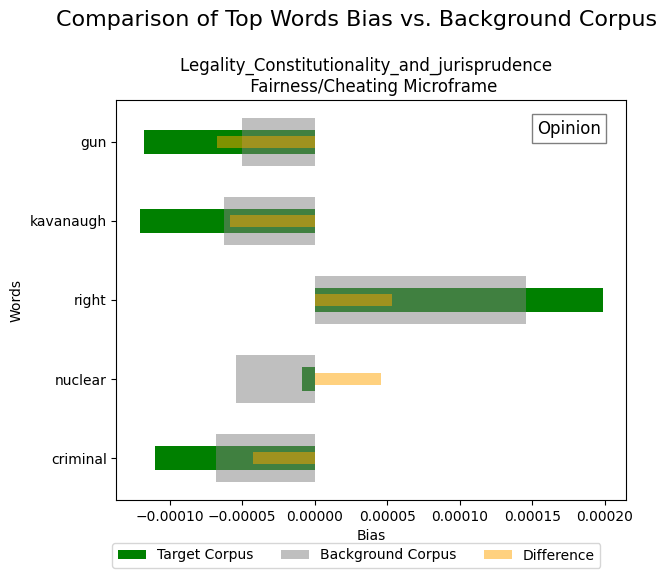

In [138]:
selected_frame_tone = ['Legality_Constitutionality_and_jurisprudence - opinion']

selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5, types=["reporting", "opinion", "satire"])

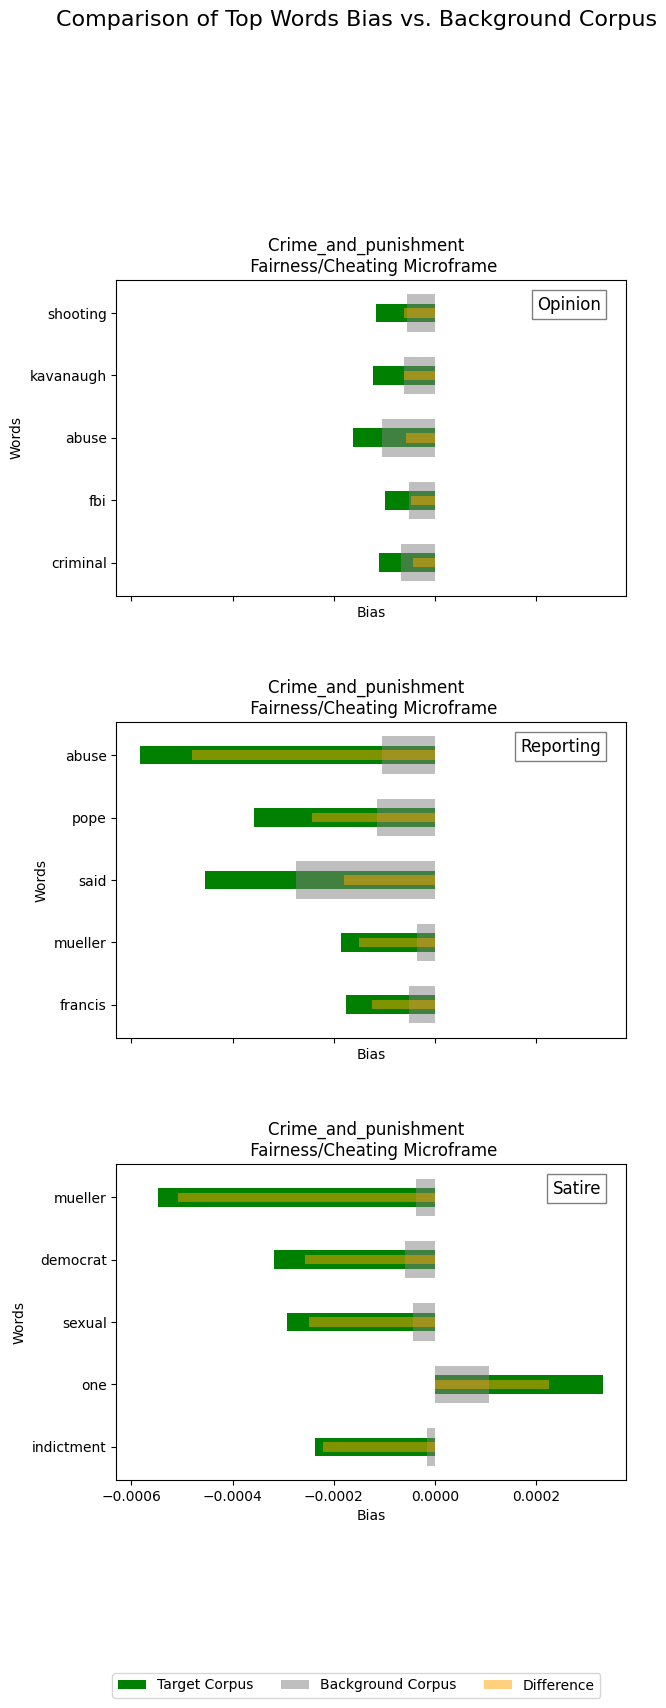

In [139]:
selected_frame_tone = ['Crime_and_punishment - opinion',
    'Crime_and_punishment - reporting',
    'Crime_and_punishment - satire']


selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

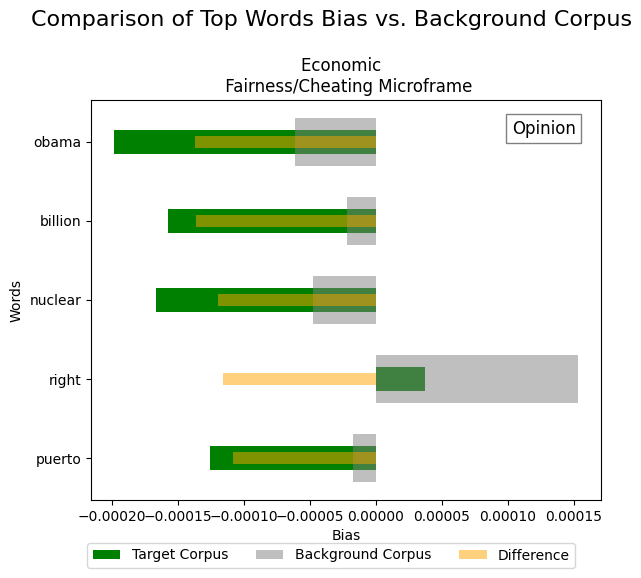

In [140]:
selected_frame_tone = ['Economic - opinion']

selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

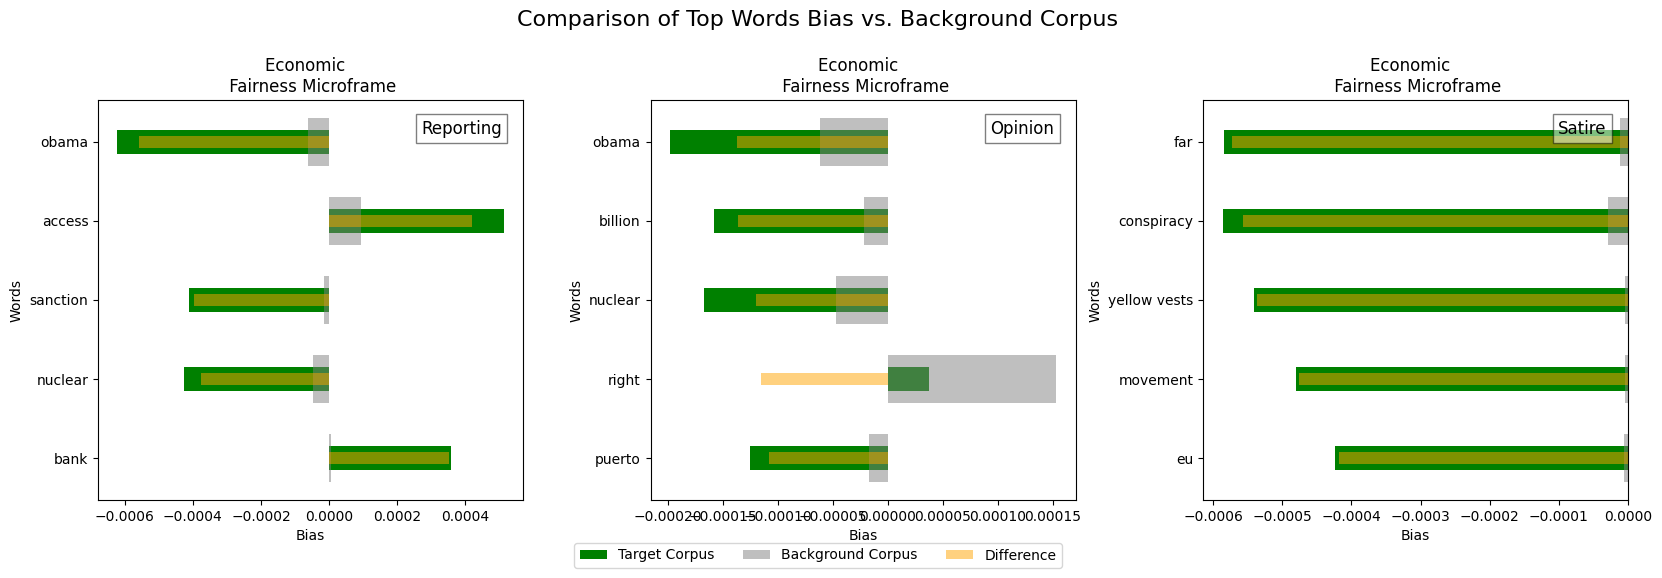

In [145]:
import matplotlib.pyplot as plt
import numpy as np

def plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_document_frames, selected_microframes, group_by_col="frame_type", top_n=10, types=["reporting", "opinion", "satire"]):
    df_merged = df_bias.merge(df_background_shift_bias, on=[group_by_col, 'word', 'microframe']).rename(columns={'bias_shift': 'bias_target'})

    # Add bias_difference
    df_merged['bias_difference'] = df_merged['bias_target'] - df_merged['bias_background']
    df_merged['abs_difference'] = df_merged['bias_difference'].abs()

    # Filter selected_document_frames based on tone_filter
    filtered_document_frames = []
    for doc_frame in selected_document_frames:
        
        type = doc_frame.split(" - ")[1]

        if type in types:
            filtered_document_frames.append(doc_frame)

    num_document_frames = len(filtered_document_frames)
    num_microframes = len(selected_microframes)

    if num_document_frames == 0 or num_microframes == 0:
        print("No frames to plot based on the tone filter.")
        return

    # Plot setup
    fig, axes = plt.subplots(1, num_document_frames, figsize=(num_document_frames * 6, num_microframes * 5), sharey=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.80, bottom=0.0, left=0.1, right=0.95)

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1:
        axes = np.array([axes])

    # Plotting
    for frame_index, doc_frame in enumerate(filtered_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index]

            # Get top_words for the selected document frame and microframe
            top_words = df_merged[(df_merged[group_by_col] == doc_frame) & (df_merged['microframe'] == microframe)].nlargest(top_n, 'abs_difference')

            # Reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus biases
            ax.barh(top_words['word'], top_words['bias_target'], height=bar_width, color='green', label='Target Corpus')

            # Plot background biases for these top words
            ax.barh(top_words['word'], top_words['bias_background'], height=bar_width*2, color='gray', alpha=0.5, label='Background Corpus')

            # Plot difference
            ax.barh(top_words['word'], top_words['bias_difference'], height=bar_width/2, color='orange', alpha=0.5, label='Difference')

            # Determine tone
            if doc_frame.split(" - ")[1] == "reporting":
                tone = "Reporting"
            elif doc_frame.split(" - ")[1] == "opinion":
                tone = "Opinion"
            elif doc_frame.split(" - ")[1] == "satire":
                tone = "Satire"

            # Add text annotation for tone
            ax.text(0.95, 0.95, tone, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

            ax.set_title(f"{doc_frame.split('-')[0]} \n {microframe_map[microframe]} Microframe")
            ax.set_xlabel('Bias')
            ax.set_ylabel('Words')

    # Legend handling
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))
    plt.suptitle('Comparison of Top Words Bias vs. Background Corpus', fontsize=16, y=0.98)
    plt.show()

selected_frame_tone = ['Economic - reporting', "Economic - opinion", "Economic - satire"]

selected_microframes = ['fairness']

# Define a mock microframe_map for the purpose of this example
microframe_map = {
    'fairness': 'Fairness'
}

# Assuming df_bias and df_background_shift_bias are already defined dataframes
plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col="frame_type", top_n=5)


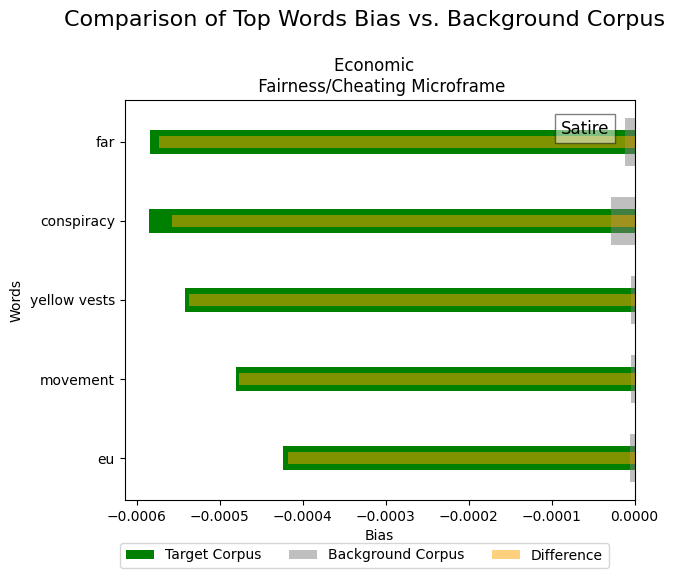

In [142]:
selected_frame_tone = ['Economic - satire']

selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

#### Plot the Intensity Shift

In [ ]:
def plot_word_intensity_comparisons(
    df_intensity,
    df_background_shift_intensity,
    selected_document_frames,
    selected_microframes,
    group_by_col="frame_type",
    top_n=10,
):
    df_merged = df_intensity.merge(
        df_background_shift_intensity, on=[group_by_col, "word", "microframe"]
    ).rename(columns={"intensity_shift": "intensity_target"})

    # Add intensity_difference
    df_merged["intensity_difference"] = (
        df_merged["intensity_target"] - df_merged["intensity_background"]
    )

    # Plot setup
    num_document_frames = len(selected_document_frames)
    num_microframes = len(selected_microframes)
    fig, axes = plt.subplots(
        num_document_frames,
        num_microframes,
        figsize=(num_microframes * 6, num_document_frames * 5),
        sharex=False,
    )
    fig.subplots_adjust(
        hspace=0.4, wspace=0.3, top=0.9, bottom=0.2, left=0.05, right=0.95
    )

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1 and num_microframes == 1:
        axes = np.array([[axes]])
    elif num_document_frames == 1:
        axes = np.array([axes])
    elif num_microframes == 1:
        axes = axes[:, np.newaxis]

    # Plotting
    for frame_index, doc_frame in enumerate(selected_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index, microframe_index]

            # Get top_words for the selected document frame and microframe
            top_words = df_merged[
                (df_merged[group_by_col] == doc_frame)
                & (df_merged["microframe"] == microframe)
            ].nlargest(top_n, "intensity_difference")

            # Reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus intensities
            ax.barh(
                top_words["word"],
                top_words["intensity_target"],
                height=bar_width,
                color="green",
                label="Target Corpus",
            )

            # Plot background intensities for these top words
            ax.barh(
                top_words["word"],
                top_words["intensity_background"],
                height=bar_width * 2,
                color="gray",
                alpha=0.5,
                label="Background Corpus",
            )

            # Plot difference
            ax.barh(
                top_words["word"],
                top_words["intensity_difference"],
                height=bar_width / 2,
                color="orange",
                alpha=0.5,
                label="Difference",
            )

            # Determine tone
            if doc_frame.split(" - ")[1] == "reporting":
                tone = "Reporting"
            elif doc_frame.split(" - ")[1] == "opinion":
                tone = "Opinion"
            elif doc_frame.split(" - ")[1] == "satire":
                tone = "Satire"

            # Add text annotation for tone
            ax.text(
                0.95,
                0.95,
                tone,
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment="top",
                horizontalalignment="right",
                bbox=dict(facecolor="white", alpha=0.5),
            )

            ax.set_title(
                f"{doc_frame.split('-')[0]} \n {microframe_map[microframe]} Microframe"
            )
            ax.set_xlabel("Intensity")
            ax.set_ylabel("Words")

            # Adjust the x-axis range to fit the data better
            max_intensity = max(top_words["intensity_target"].max(), top_words["intensity_background"].max())
            ax.set_xlim(0, max_intensity * 1.1)  # Add some padding

    # Legend handling
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3)
    fig.suptitle(
        "Comparison of Top Words Intensity vs. Background Corpus", fontsize=16, y=0.98
    )
    plt.show()

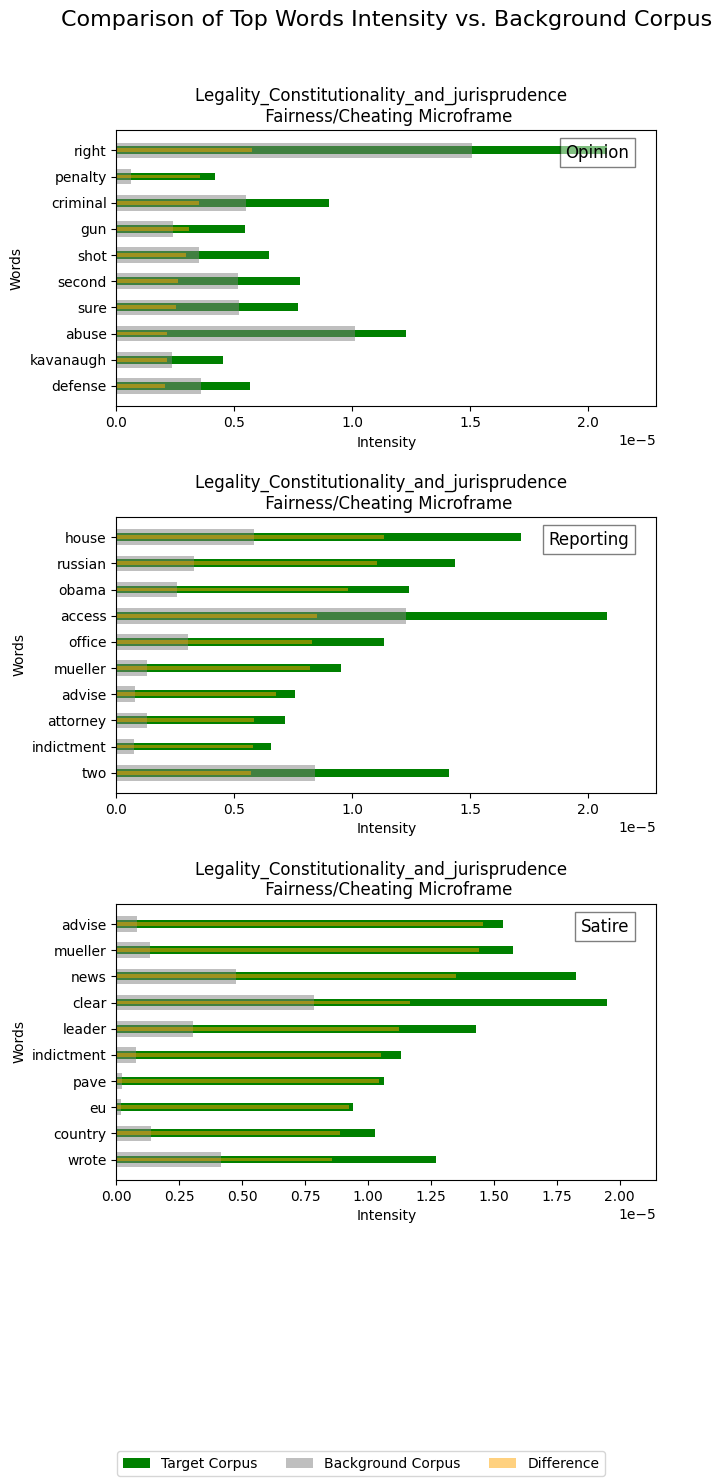

In [ ]:
selected_frame_tone = [
       'Legality_Constitutionality_and_jurisprudence - opinion',
       'Legality_Constitutionality_and_jurisprudence - reporting',
       'Legality_Constitutionality_and_jurisprudence - satire',
]

selected_frames = [
    "Quality of Life",
    "Legality, Constitutionality, Jurisdiction",
    "Capacity and Resources",
    "Cultural Identity",
    "Health and Safety",
    "Security and Defense",
    "Economic",
    "Crime and Punishment",
    "External Regulation and Reputation",
    "Political",
    "Fairness and Equality",
    "Policy Presecription and Evaluation",
    "Morality",
    "Public Sentiment",
    "Other",
]
selected_microframes = ["fairness"]

plot_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frame_tone,
    selected_microframes,
    group_by_col=group_by_col,
    top_n=10,
)

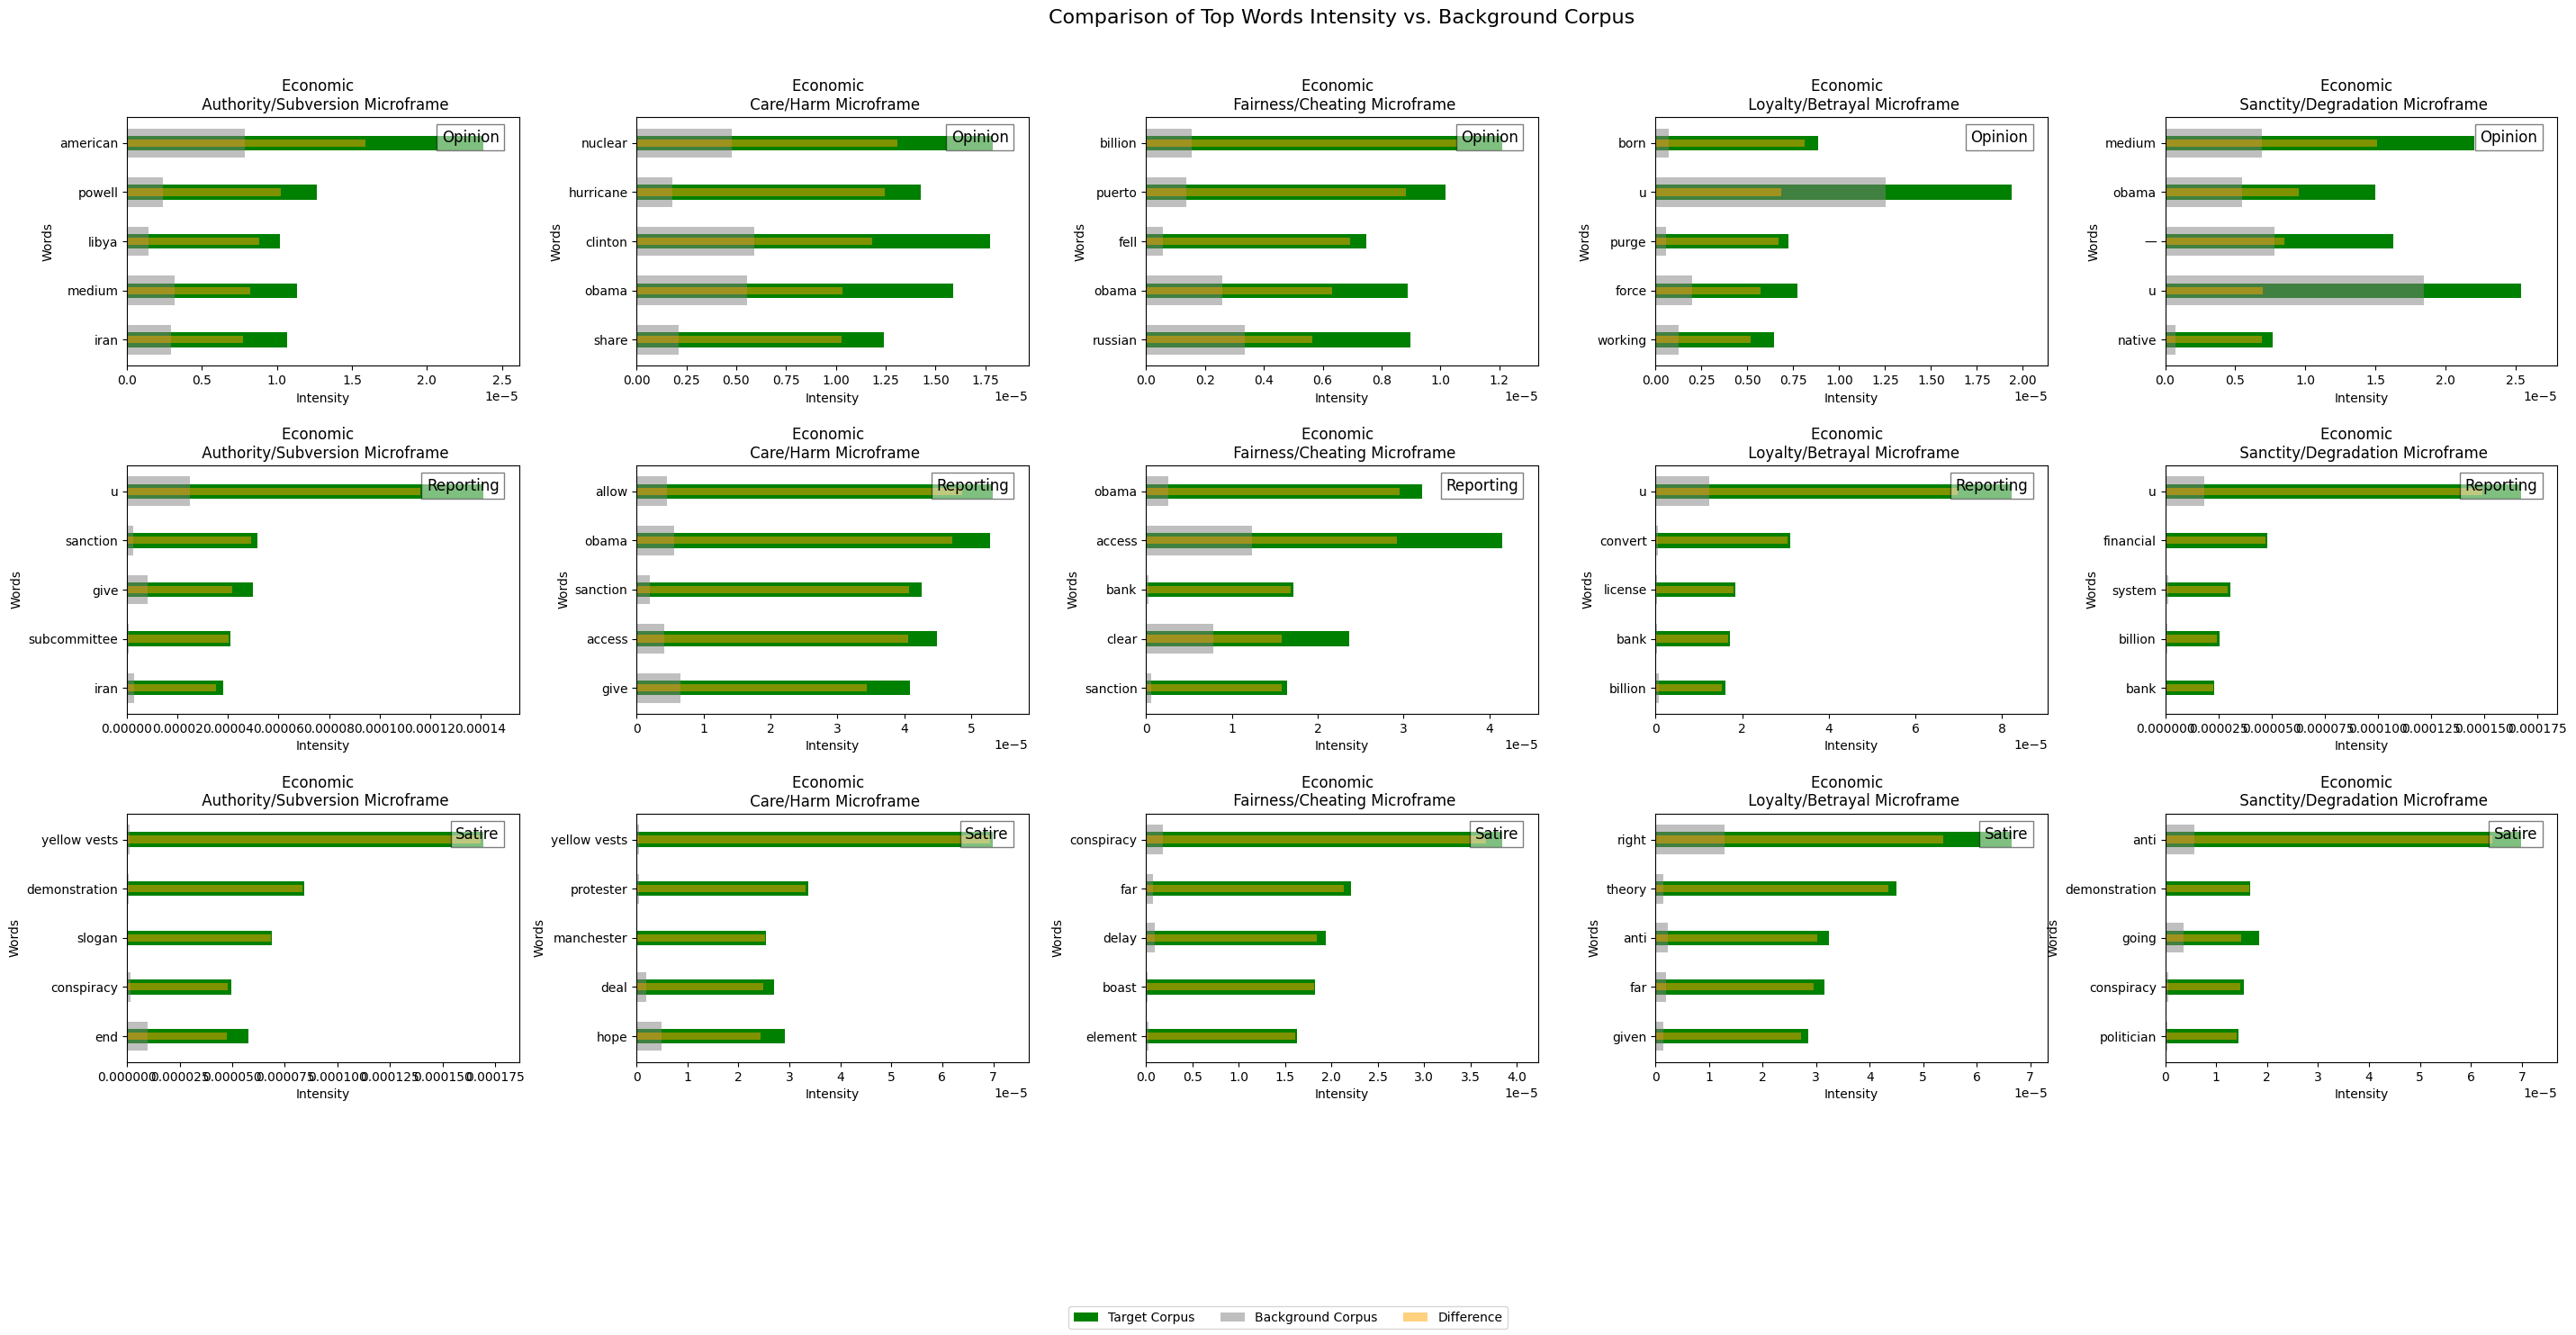

In [ ]:
selected_frame_tone = [
       'Economic - opinion', 'Economic - reporting', 'Economic - satire',
]

selected_frames = [
    "Quality of Life",
    "Legality, Constitutionality, Jurisdiction",
    "Capacity and Resources",
    "Cultural Identity",
    "Health and Safety",
    "Security and Defense",
    "Economic",
    "Crime and Punishment",
    "External Regulation and Reputation",
    "Political",
    "Fairness and Equality",
    "Policy Presecription and Evaluation",
    "Morality",
    "Public Sentiment",
    "Other",
]
selected_microframes = ["authority", "care", "fairness", "loyalty", "sanctity"]

plot_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frame_tone,
    selected_microframes,
    group_by_col=group_by_col,
    top_n=5,
)

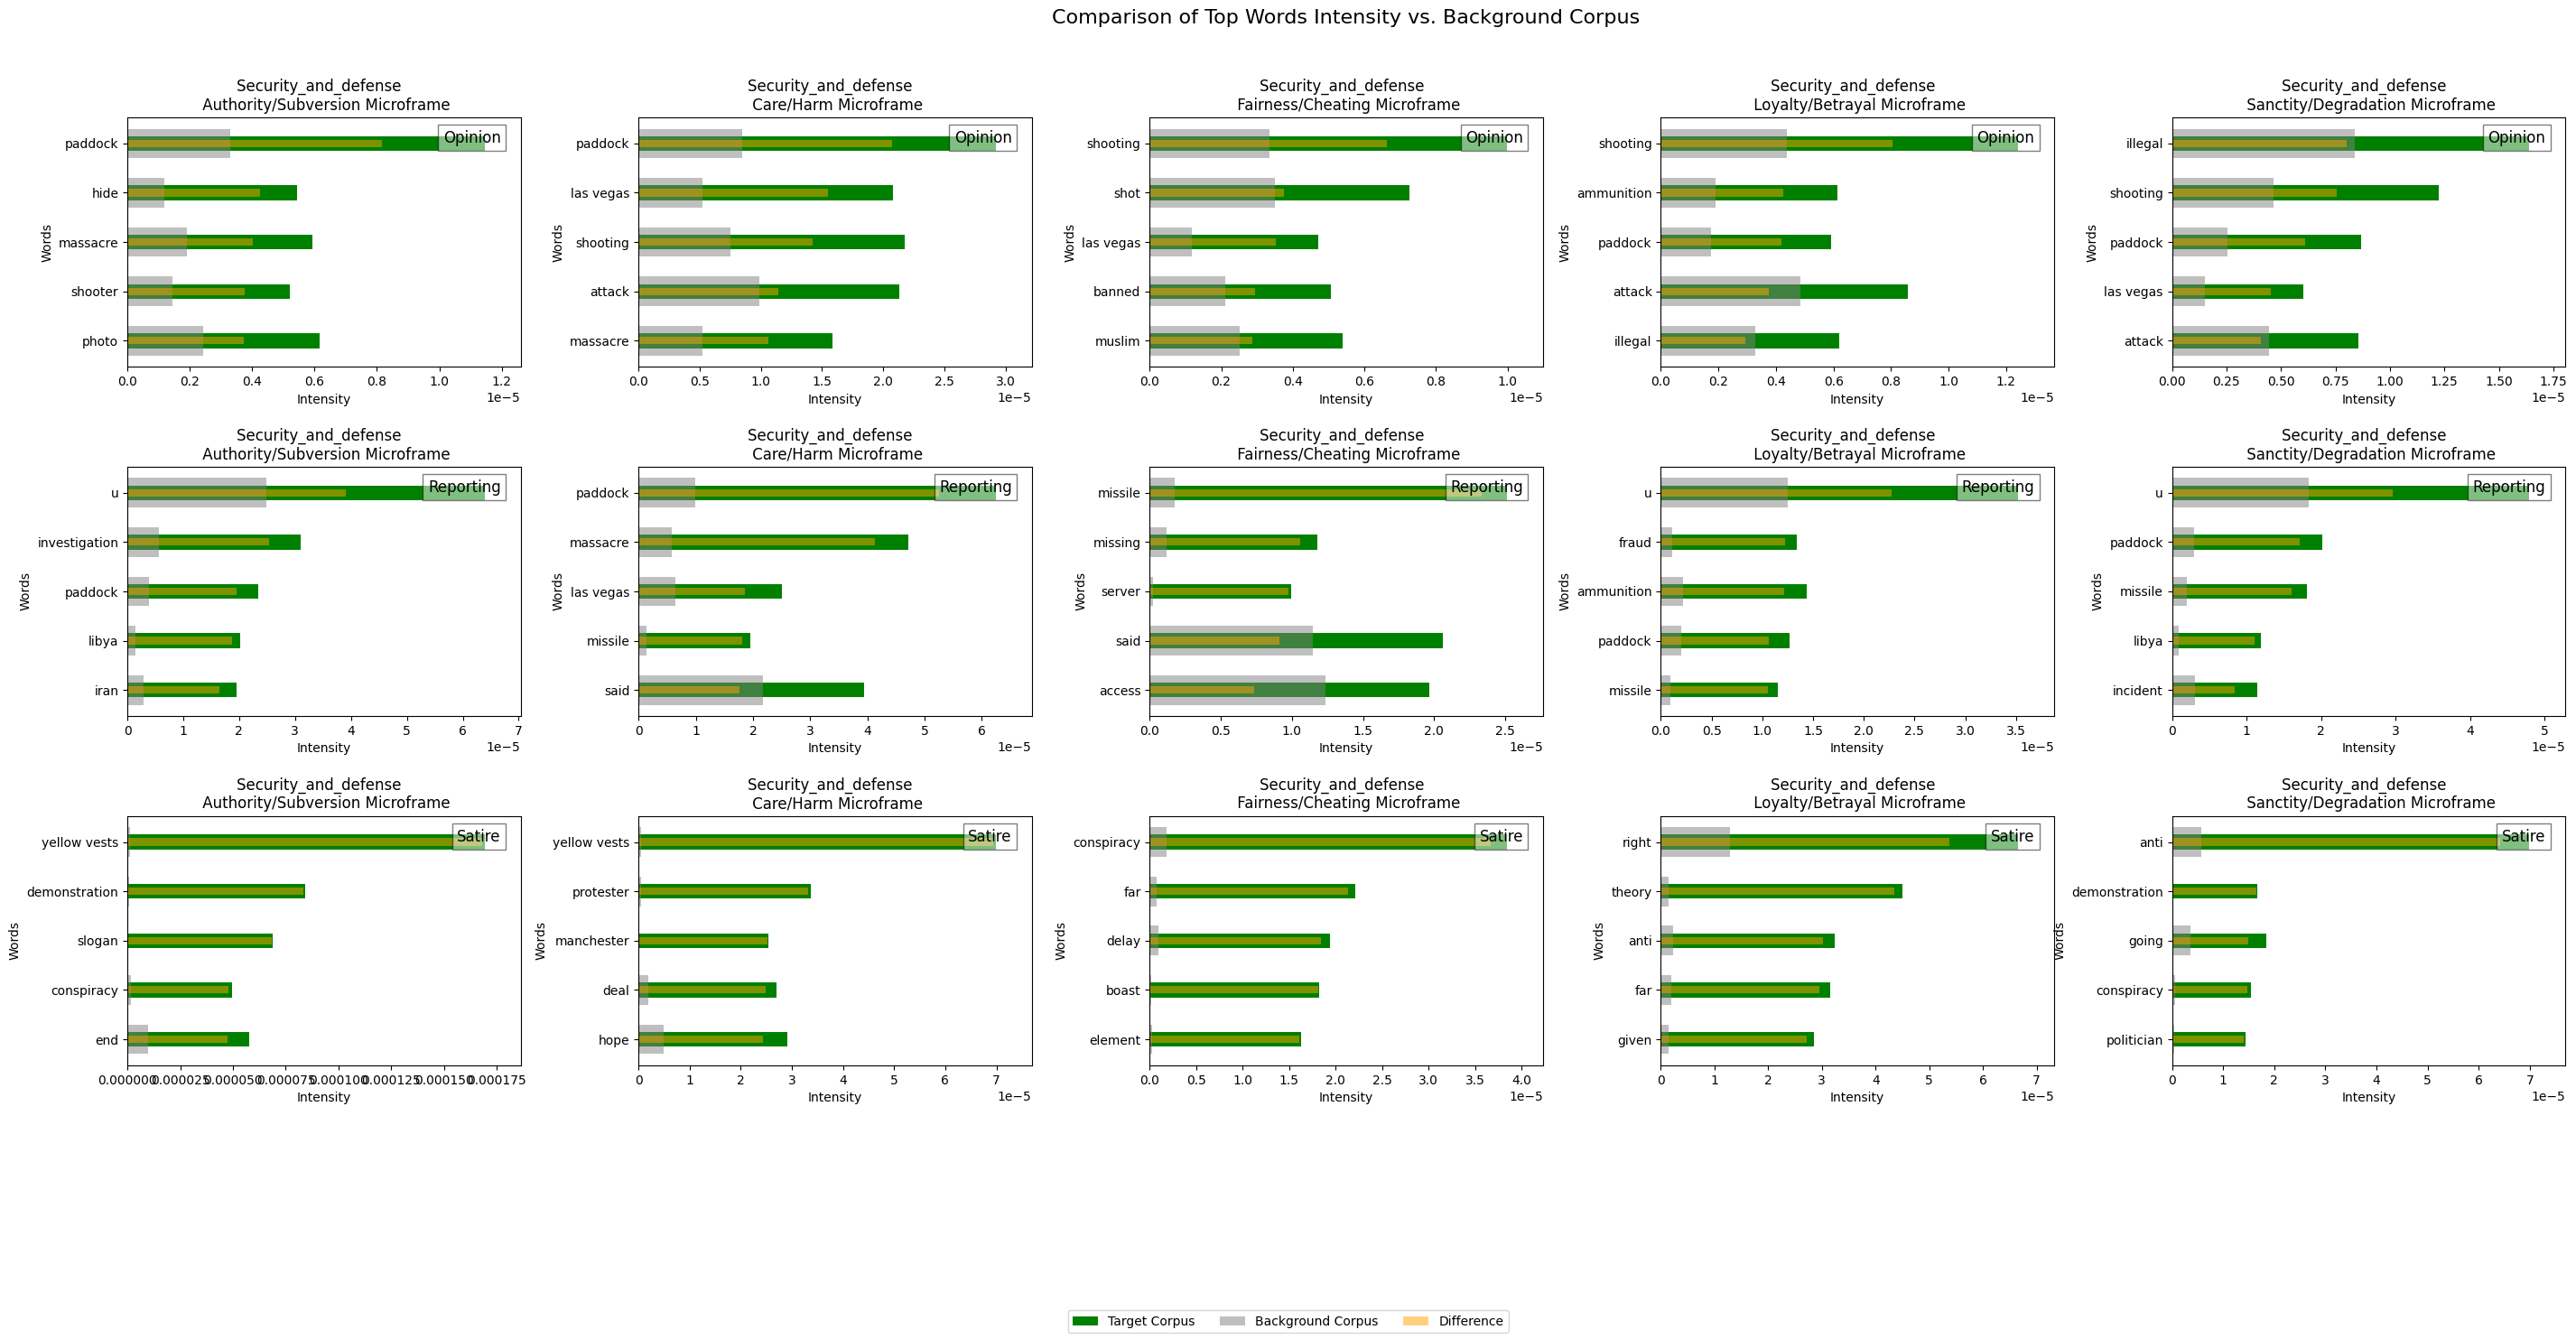

In [ ]:
selected_frame_tone = [
       'Security_and_defense - opinion',
       'Security_and_defense - reporting',
       'Security_and_defense - satire'
]

selected_frames = [
    "Quality of Life",
    "Legality, Constitutionality, Jurisdiction",
    "Capacity and Resources",
    "Cultural Identity",
    "Health and Safety",
    "Security and Defense",
    "Economic",
    "Crime and Punishment",
    "External Regulation and Reputation",
    "Political",
    "Fairness and Equality",
    "Policy Presecription and Evaluation",
    "Morality",
    "Public Sentiment",
    "Other",
]
selected_microframes = ["authority", "care", "fairness", "loyalty", "sanctity"]

plot_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frame_tone,
    selected_microframes,
    group_by_col=group_by_col,
    top_n=5,
)

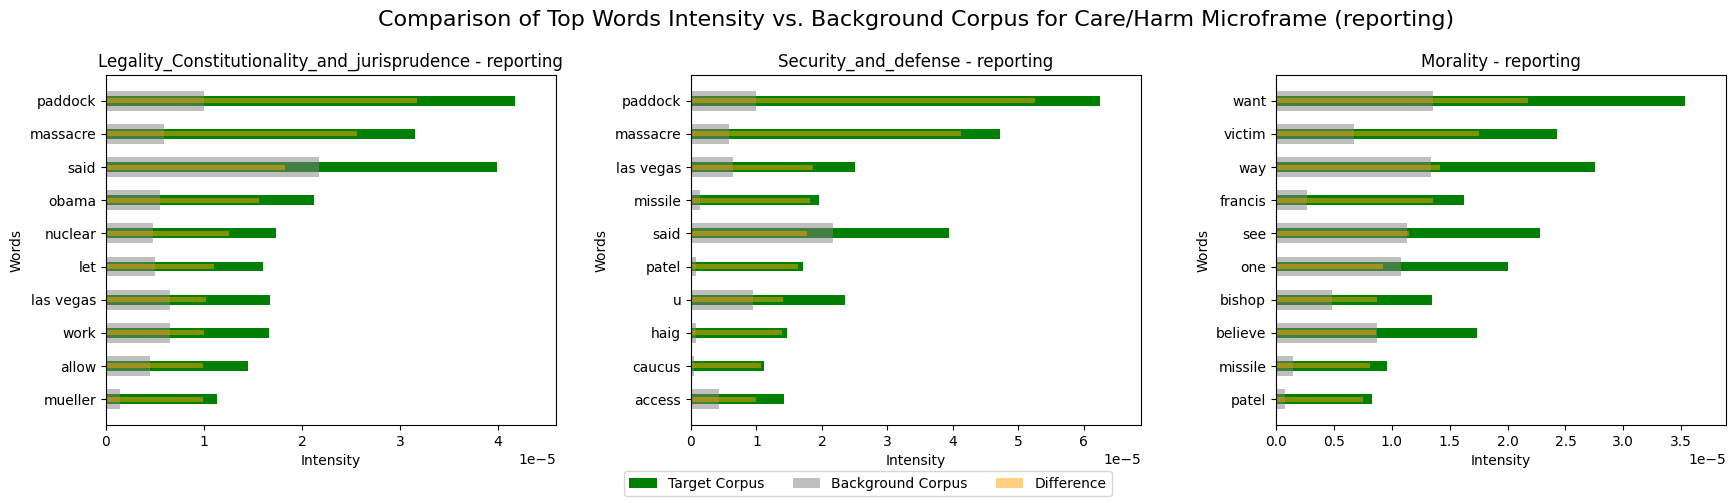

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_specific_word_intensity_comparisons(
    df_intensity,
    df_background_shift_intensity,
    selected_frames,
    selected_type="opinion",
    microframe="care",
    group_by_col="frame_type",
    top_n=10,
):
    df_merged = df_intensity.merge(
        df_background_shift_intensity, on=[group_by_col, "word", "microframe"]
    ).rename(columns={"intensity_shift": "intensity_target"})

    # add intensity_difference
    df_merged["intensity_difference"] = (
        df_merged["intensity_target"] - df_merged["intensity_background"]
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.85, bottom=0.15, left=0.05, right=0.95)

    for col_index, frame in enumerate(selected_frames):
        ax = axes[col_index]

        # get top_words for the selected document frame and microframe
        top_words = df_merged[
            (df_merged[group_by_col].str.contains(frame))
            & (df_merged[group_by_col].str.contains(selected_type))
            & (df_merged["microframe"] == microframe)
        ].nlargest(top_n, "intensity_difference")

        # reverse the order of the top_words
        top_words = top_words.iloc[::-1]

        bar_width = 0.3

        # Plot target corpus intensities
        ax.barh(
            top_words["word"],
            top_words["intensity_target"],
            height=bar_width,
            color="green",
            label="Target Corpus"
        )

        # Plot background intensities for these top words
        ax.barh(
            top_words["word"],
            top_words["intensity_background"],
            height=bar_width * 2,
            color="gray",
            alpha=0.5,
            label="Background Corpus"
        )

        # Plot difference
        ax.barh(
            top_words["word"],
            top_words["intensity_difference"],
            height=bar_width / 2,
            color="orange",
            alpha=0.5,
            label="Difference"
        )

        ax.set_title(f"{frame} - {selected_type}")
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Words")

        # Adjust the x-axis range to fit the data better
        max_intensity = max(top_words["intensity_target"].max(), top_words["intensity_background"].max())
        ax.set_xlim(0, max_intensity * 1.1)  # Add some padding

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3)
    fig.suptitle(f"Comparison of Top Words Intensity vs. Background Corpus for Care/Harm Microframe ({selected_type})", fontsize=16, y=0.98)
    plt.show()

selected_frames = [
    "Legality_Constitutionality_and_jurisprudence",
    "Security_and_defense",
    "Morality"
]

plot_specific_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frames,
    selected_type="reporting",
    microframe="care",
    group_by_col="frame_type",
    top_n=10,
)


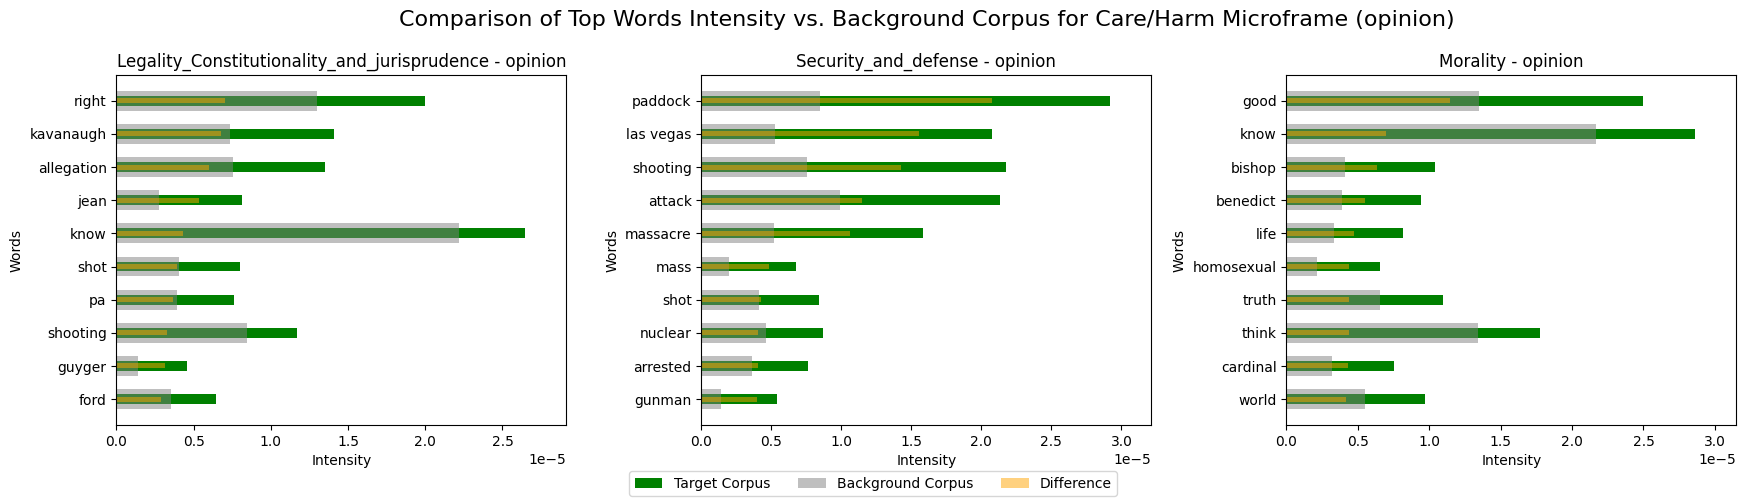

In [ ]:
plot_specific_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frames,
    selected_type="opinion",
    microframe="care",
    group_by_col="frame_type",
    top_n=10,
)


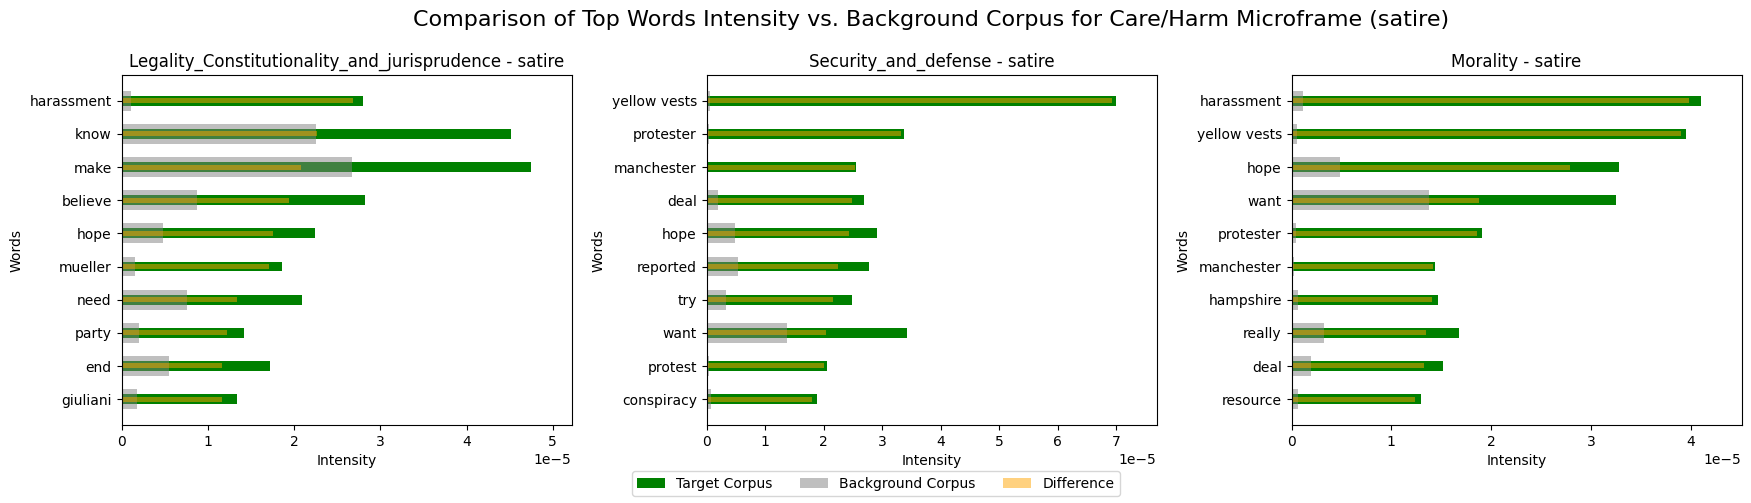

In [ ]:
plot_specific_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frames,
    selected_type="satire",
    microframe="care",
    group_by_col="frame_type",
    top_n=10,
)
